<a href="https://colab.research.google.com/github/KsuZavyalova/APCL_ZavyalovaKsenia/blob/main/03_homework.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Задание 1 (5 балла)

Имплементируйте алгоритм Леска (описание есть в семинаре) и оцените качество его работы на датасете `data/corpus_wsd_50k.txt`

В качестве метрики близости вы должны попробовать два подхода:

1) Jaccard score на множествах слов (определений и контекста)
2) Cosine distance на эмбедингах sentence_transformers

В качестве метрики используйте accuracy (% правильных ответов). Предсказывайте только многозначные слова в датасете

Контекст вы можете определить самостоятельно (окно вокруг целевого слова или все предложение). Также можете поэкспериментировать с предобработкой для обоих методов.

In [5]:
import string
import torch
import numpy as np
from nltk.corpus import stopwords, wordnet as wn
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util

# sentence-transformers модель на GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device=device)

stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

In [3]:
import nltk

In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [12]:
import string
import torch
from nltk.corpus import stopwords, wordnet as wn
from tqdm import tqdm
from sentence_transformers import SentenceTransformer, util

# sentence-transformers модель на GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device=device)

stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)



In [13]:

# --- предрасчёт эмбеддингов gloss-ов ---
print("Предрасчёт эмбеддингов для WordNet...")

synset_embeddings = {}
all_synsets = list(wn.all_synsets())

for syn in tqdm(all_synsets, desc="Encoding glosses"):
    gloss = syn.definition() + " " + " ".join(syn.examples())
    if gloss.strip():
        synset_embeddings[syn] = model.encode(gloss, convert_to_tensor=True, device=device)
    else:
        synset_embeddings[syn] = None

print(f"Готово: {len(synset_embeddings)} gloss-эмбеддингов")

Предрасчёт эмбеддингов для WordNet...


Encoding glosses: 100%|██████████| 117659/117659 [24:44<00:00, 79.25it/s]

Готово: 117659 gloss-эмбеддингов


In [16]:
# нормализация для Jaccard
def normalize(text):
    return [w.lower() for w in text.split() if w.lower() not in stop_words and w not in punctuation]

def jaccard(set1, set2):
    if not set1 or not set2:
        return 0
    return len(set1 & set2) / len(set1 | set2)

def lesk_disambiguate(lemma, context_tokens, method="jaccard"):
    synsets = wn.synsets(lemma)
    if len(synsets) <= 1:
        return None  # слово не многозначное

    best_sense = None
    best_score = -1

    if method == "jaccard":
        context_set = set(context_tokens)
    elif method == "cosine":
        context_emb = model.encode(" ".join(context_tokens), convert_to_tensor=True, device=device)

    for syn in synsets:
        if method == "jaccard":
            gloss = syn.definition() + " " + " ".join(syn.examples())
            gloss_tokens = set(normalize(gloss))
            score = jaccard(context_set, gloss_tokens)

        elif method == "cosine":
            gloss_emb = synset_embeddings.get(syn, None)
            if gloss_emb is None:
                continue
            score = float(util.cos_sim(context_emb, gloss_emb))

        if score > best_score:
            best_score = score
            best_sense = syn

    return best_sense

def sense_match(sense_key, synset):
    if not synset:
        return False
    wn_name = synset.name()  # "long.a.01"
    return sense_key.startswith(wn_name.split('.')[0] + "%") or sense_key.startswith(wn_name.replace('.', '%'))

def evaluate_lesk(corpus_wsd, context_type="sentence", method="jaccard", batch_size=32):
    correct, total = 0, 0

    for sentence in tqdm(corpus_wsd, desc=f"Lesk-{context_type}-{method}"):
        lemmas = [t[1].lower() for t in sentence if len(t) >= 2]

        contexts, target_infos = [], []
        for token_idx, token in enumerate(sentence):
            if len(token) < 3:
                continue
            sense_key, lemma, word_form = token[0], token[1].lower(), token[2]
            if not sense_key:
                continue

            synsets = wn.synsets(lemma)
            if len(synsets) <= 1:
                continue

            if context_type == "sentence":
                context = [w for i, w in enumerate(lemmas) if i != token_idx]
            elif context_type == "window5":
                start = max(0, token_idx - 5)
                end = min(len(lemmas), token_idx + 6)
                context = [lemmas[i] for i in range(start, end) if i != token_idx]
            elif context_type == "window3":
                start = max(0, token_idx - 3)
                end = min(len(lemmas), token_idx + 4)
                context = [lemmas[i] for i in range(start, end) if i != token_idx]

            if method == "jaccard":
                context_tokens = normalize(" ".join(context))
                predicted_syn = lesk_disambiguate(lemma, context_tokens, method=method)
                if sense_match(sense_key, predicted_syn):
                    correct += 1
                total += 1
            else:
                # для cosine сохраним контекст и инфу
                contexts.append(" ".join(context))
                target_infos.append((sense_key, lemma))

        if method == "cosine" and contexts:
            # матрица эмбеддингов контекстов
            context_embs = model.encode(
                contexts,
                convert_to_tensor=True,
                batch_size=batch_size,
                device=device,
                show_progress_bar=False
            )
            for idx, (sense_key, lemma) in enumerate(target_infos):
                synsets = wn.synsets(lemma)
                emb = context_embs[idx]
                best_sense, best_score = None, -1
                for syn in synsets:
                    gloss_emb = synset_embeddings.get(syn, None)
                    if gloss_emb is None:
                        continue
                    score = float(util.cos_sim(emb, gloss_emb))
                    if score > best_score:
                        best_sense, best_score = syn, score
                if sense_match(sense_key, best_sense):
                    correct += 1
                total += 1

    acc = correct / total if total > 0 else 0
    return acc, correct, total

corpus_wsd = []
corpus = open('corpus_wsd_50k.txt').read().split('\n\n')
for sent in corpus:
    corpus_wsd.append([s.split('\t') for s in sent.split('\n')])

acc_sent, c1, t1 = evaluate_lesk(corpus_wsd, context_type="sentence")
print(f"Accuracy (всё предложение): {acc_sent:.4f} ({c1}/{t1})")

acc_win, c2, t2 = evaluate_lesk(corpus_wsd, context_type="window5")
print(f"Accuracy (окно ±5 слов): {acc_win:.4f} ({c2}/{t2})")

acc_win, c3, t3 = evaluate_lesk(corpus_wsd, context_type="window3")
print(f"Accuracy (окно ±3 слов): {acc_win:.4f} ({c2}/{t2})")

acc_win, c4, t4 = evaluate_lesk(corpus_wsd, context_type="window5", method="cosine")
print(f"Cosine | Accuracy (окно ±5 слов): {acc_win:.4f} ({c4}/{t4})")


Lesk-sentence-jaccard: 100%|██████████| 49453/49453 [00:28<00:00, 1712.82it/s]


Accuracy (всё предложение): 0.6684 (143096/214096)


Lesk-window5-jaccard: 100%|██████████| 49453/49453 [00:26<00:00, 1860.83it/s]


Accuracy (окно ±5 слов): 0.6683 (143083/214096)


Lesk-window3-jaccard: 100%|██████████| 49453/49453 [00:25<00:00, 1909.37it/s]


Accuracy (окно ±3 слов): 0.6693 (143083/214096)


Lesk-window5-cosine: 100%|██████████| 49453/49453 [17:02<00:00, 48.36it/s]

Cosine | Accuracy (окно ±5 слов): 0.6662 (142630/214096)


In [22]:
gloss_cache = {}

def normalize(text):
    return [w.lower() for w in text.split() if w.lower() not in stop_words and w not in punctuation]

def sense_match(sense_key, synset):
    if not synset:
        return False
    wn_name = synset.name()
    return sense_key.startswith(wn_name.split('.')[0] + "%") or sense_key.startswith(wn_name.replace('.', '%'))

def build_gloss_cache(batch_size=64):
    global gloss_cache
    all_synsets = list(wn.all_synsets())
    gloss_texts, syn_refs = [], []

    for syn in all_synsets:
        gloss = syn.definition() + " " + " ".join(syn.examples())
        gloss_tokens = normalize(gloss)
        if gloss_tokens:
            gloss_texts.append(" ".join(gloss_tokens))
            syn_refs.append(syn)

    print(f"Всего глоссов для кодирования: {len(gloss_texts)}")
    gloss_embs = model.encode(
        gloss_texts,
        convert_to_tensor=True,
        batch_size=batch_size,
        device=device,
        show_progress_bar=True
    )

    gloss_cache = {syn: emb for syn, emb in zip(syn_refs, gloss_embs)}
    print(f"Кэш готов: {len(gloss_cache)} глоссов закодировано")


In [23]:
build_gloss_cache(batch_size=128)

Всего глоссов для кодирования: 117658


Batches:   0%|          | 0/920 [00:00<?, ?it/s]

Кэш готов: 117658 глоссов закодировано


In [24]:
def evaluate_lesk_cosine_precomputed(corpus_wsd, batch_size=128):
    correct, total = 0, 0

    for sentence in tqdm(corpus_wsd, desc="Lesk-window5-cosine"):
        lemmas = [t[1].lower() for t in sentence if len(t) >= 2]

        contexts, target_infos = [], []
        for token_idx, token in enumerate(sentence):
            if len(token) < 3:
                continue
            sense_key, lemma, word_form = token[0], token[1].lower(), token[2]
            if not sense_key:
                continue

            synsets = wn.synsets(lemma)
            if len(synsets) <= 1:
                continue

            # окно ±5 слов
            start = max(0, token_idx - 5)
            end = min(len(lemmas), token_idx + 6)
            context = [lemmas[i] for i in range(start, end) if i != token_idx]

            context_tokens = normalize(" ".join(context))
            if not context_tokens:
                continue

            contexts.append(" ".join(context_tokens))
            target_infos.append((sense_key, lemma))

        if contexts:
            # эмбеддинги контекстов батчом
            context_embs = model.encode(
                contexts,
                convert_to_tensor=True,
                batch_size=batch_size,
                device=device,
                show_progress_bar=False
            )

            for idx, (sense_key, lemma) in enumerate(target_infos):
                emb = context_embs[idx]
                synsets = wn.synsets(lemma)

                valid_syns = [syn for syn in synsets if syn in gloss_cache]
                if not valid_syns:
                    continue

                gloss_embs = torch.stack([gloss_cache[syn] for syn in valid_syns])
                sims = util.cos_sim(emb, gloss_embs)[0]
                best_idx = int(sims.argmax())
                best_sense = valid_syns[best_idx]

                if sense_match(sense_key, best_sense):
                    correct += 1
                total += 1

    acc = correct / total if total > 0 else 0
    return acc, correct, total

corpus_wsd = []
with open('corpus_wsd_50k.txt') as f:
    corpus = f.read().split('\n\n')
for sent in corpus:
    corpus_wsd.append([s.split('\t') for s in sent.split('\n')])

acc, c, t = evaluate_lesk_cosine_precomputed(corpus_wsd, batch_size=32)
print(f"Cosine | Accuracy (окно ±5 слов): {acc:.4f} ({c}/{t})")


Lesk-window5-cosine: 100%|██████████| 49453/49453 [11:30<00:00, 71.60it/s]

Cosine | Accuracy (окно ±5 слов): 0.6576 (140290/213333)


# Задание 2 (5 балла)
Попробуйте разные алгоритмы кластеризации на датасете - `https://github.com/nlpub/russe-wsi-kit/blob/initial/data/main/wiki-wiki/train.csv`

Используйте код из семинара как основу. Используйте ARI как метрику качества.

Попробуйте все 4 алгоритма кластеризации, про которые говорилось на семинаре. Для каждого из алгоритмов попробуйте настраивать гиперпараметры (посмотрите их в документации). Прогоните как минимум 5 экспериментов (не обязательно успешных) с разными параметрами на каждый алгоритме кластеризации и оцените: качество кластеризации, скорость работы, интуитивность параметров.

Помимо этого также выберите 1 дополнительный алгоритм кластеризации отсюда - https://scikit-learn.org/stable/modules/clustering.html , опишите своими словами принцип его работы  и проделайте аналогичные эксперименты.

In [1]:
!pip install pymorphy3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 16.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import re
from sentence_transformers import SentenceTransformer
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
import pymorphy3
from nltk.corpus import stopwords

In [3]:
import nltk
nltk.download('stopwords')
russian_stopwords = set(stopwords.words('russian'))
morph = pymorphy3.MorphAnalyzer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
df = pd.read_csv('https://raw.githubusercontent.com/nlpub/russe-wsi-kit/initial/data/main/wiki-wiki/train.csv', sep='\t')

In [5]:
df

context_id   word  gold_sense_id  predict_sense_id  \
0             1  замок              1               NaN   
1             2  замок              1               NaN   
2             3  замок              1               NaN   
3             4  замок              1               NaN   
4             5  замок              1               NaN   
..          ...    ...            ...               ...   
434         435    бор              2               NaN   
435         436    бор              2               NaN   
436         437    бор              2               NaN   
437         438    бор              2               NaN   
438         439    бор              2               NaN   

                                             positions  \
0                                         0-5, 339-344   
1                                11-16, 17-22, 188-193   
2                                              299-304   
3                                              111-116   
4                                     134-139, 262-267   
..                                                 ...   
434                                              10-13   
435  101-104, 149-152, 207-210, 259-262, 352-355, 4...   
436                   17-20, 138-141, 262-265, 310-313   
437                                            183-186   
438                                11-14, 26-29, 32-35   

                                               context  
0    замок владимира мономаха в любече . многочисле...  
1    шильонский замок замок шильйон ( ) , известный...  
2    проведения архитектурно - археологических рабо...  
3    топи с . , л . белокуров легенда о завещании м...  
4    великий князь литовский гедимин после успешной...  
..                                                 ...  
434  ленточный бор ле́нточные бо́ры — сосновые трав...  
435  в окрестностях барнаула , составляет —  км . н...  
436  также в сосновом бору открыта секция биатлона ...  
437  экспресс банк , мособлбанк , внешпромбанк , ба...  
438  каштакский бор каштакский бор — бор , находящи...  

[439 rows x 6 columns]

In [6]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^а-яё\s]', '', text)  # оставляем только кириллицу
    text = re.sub(r'\s+', ' ', text).strip()
    return text

In [7]:
def preprocess_no_stopwords(text):
    text = preprocess_text(text)
    tokens = [w for w in text.split() if w not in russian_stopwords]
    return ' '.join(tokens)

In [8]:
def preprocess_lemmatize(text):
    text = preprocess_no_stopwords(text)
    tokens = [morph.parse(w)[0].normal_form for w in text.split()]
    return ' '.join(tokens)

In [26]:
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2')
batch_size = 4

In [30]:
embeddings_dict = {}
embeddings_dict['clean'] = model.encode(df['context'].apply(preprocess_text).tolist(), convert_to_numpy=True, batch_size=batch_size)
embeddings_dict['no_stop'] = model.encode(df['context'].apply(preprocess_no_stopwords).tolist(), convert_to_numpy=True, batch_size=batch_size)
embeddings_dict['lemma'] = model.encode(df['context'].apply(preprocess_lemmatize).tolist(), convert_to_numpy=True, batch_size=batch_size)

In [33]:
embedding_types = ['clean', 'no_stop', 'lemma']

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


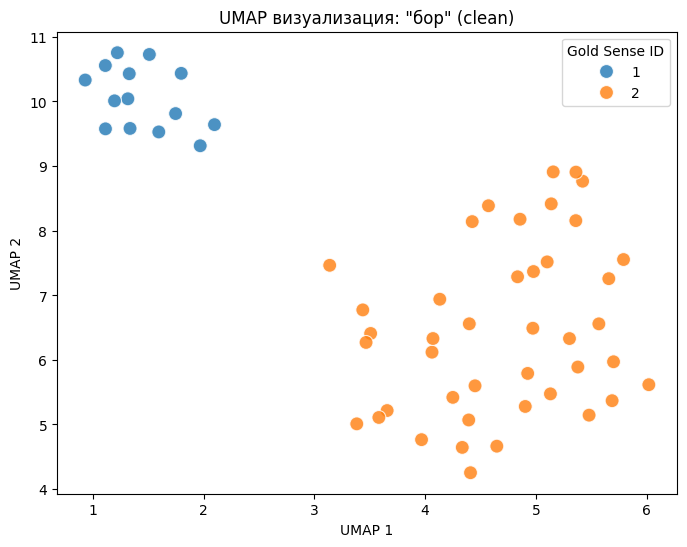

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


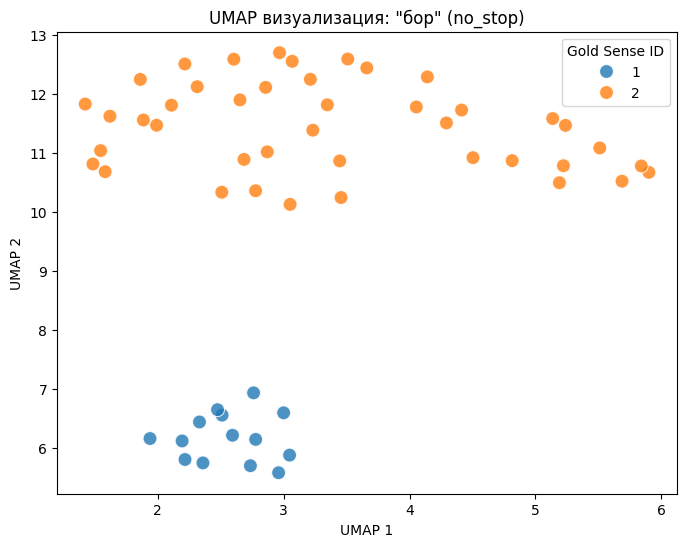

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


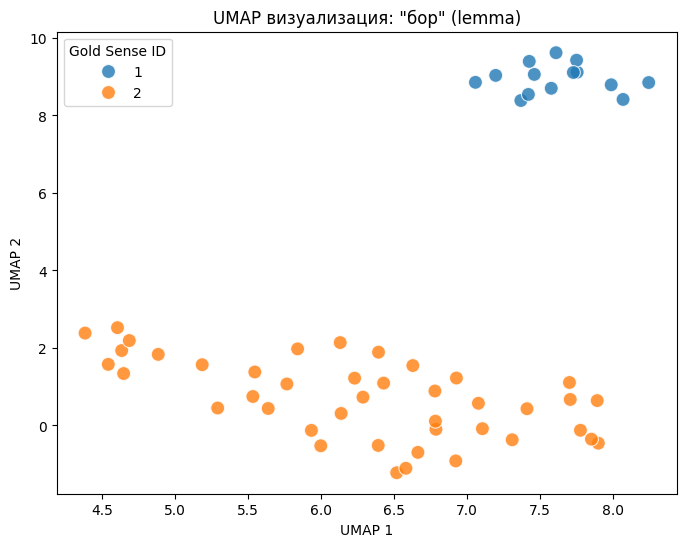

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


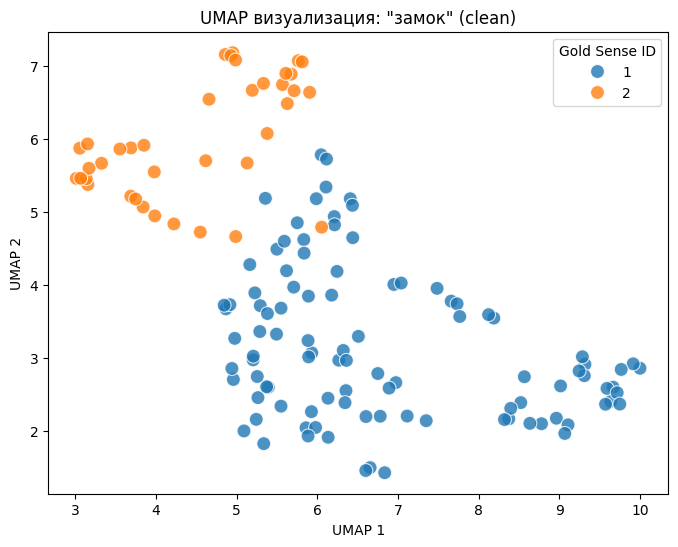

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


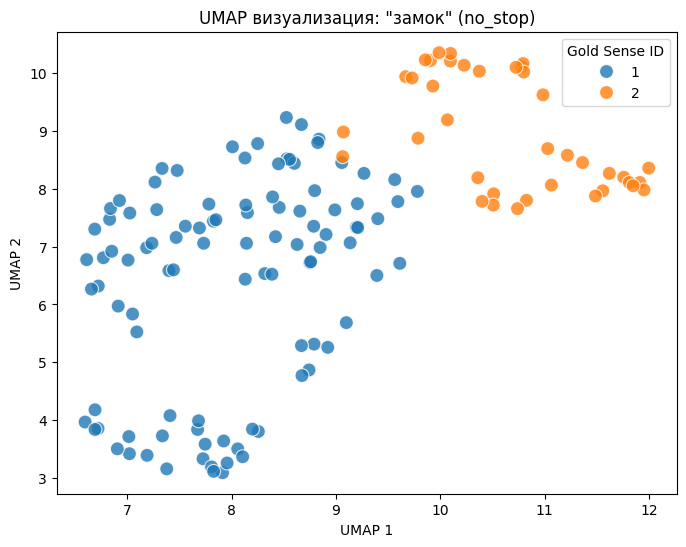

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


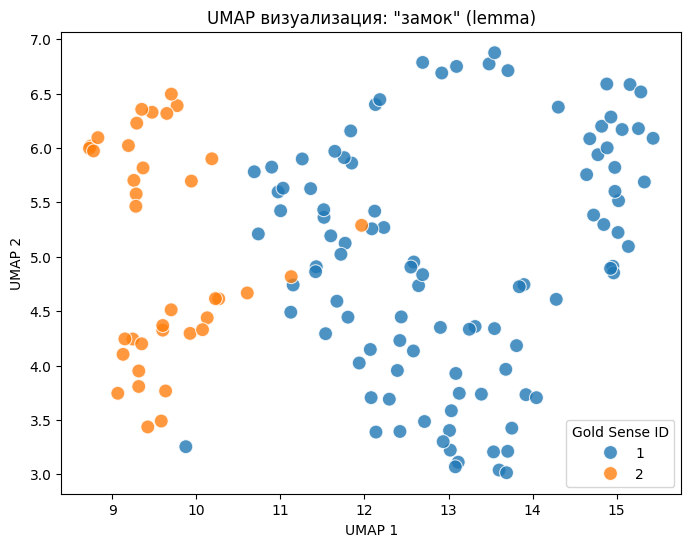

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


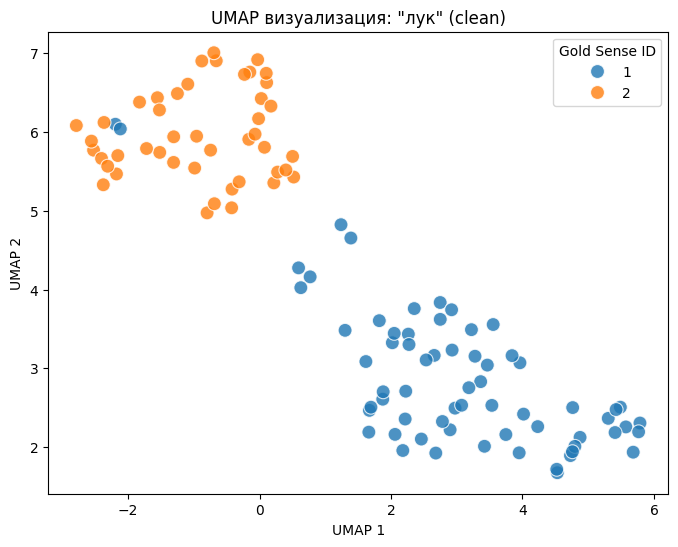

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


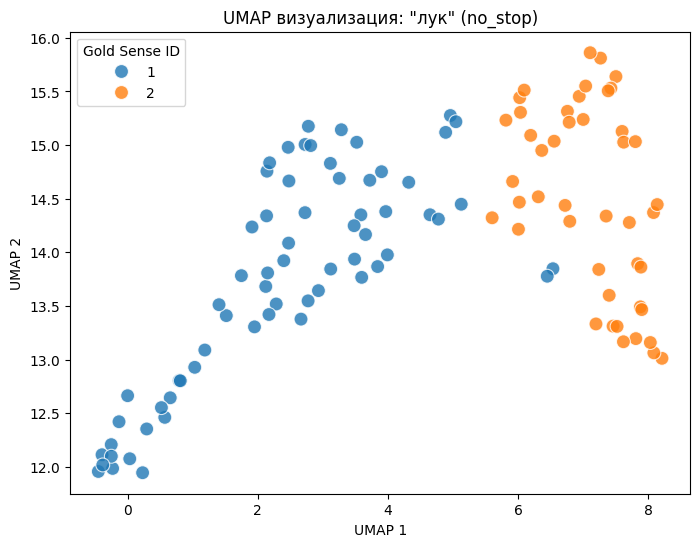

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


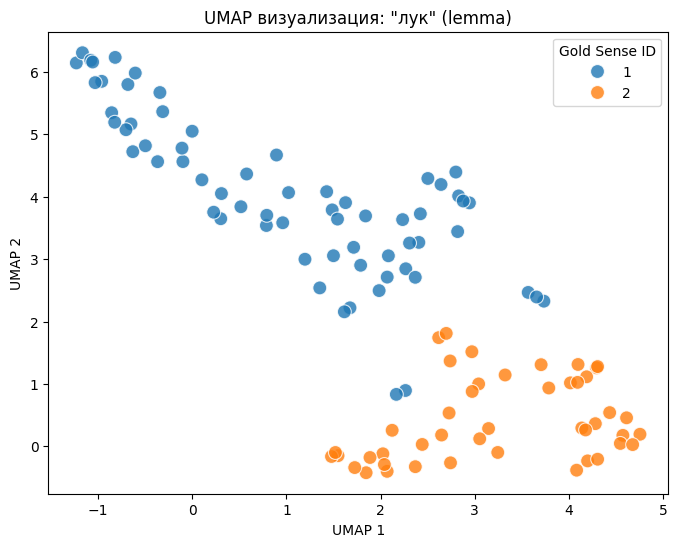

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


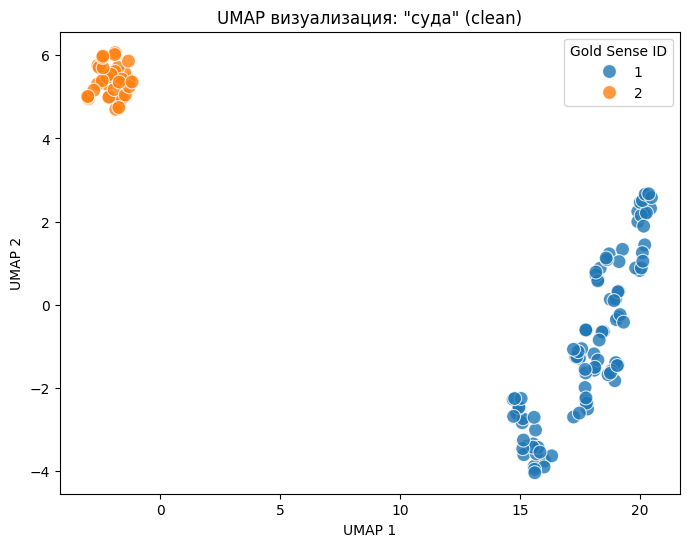

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


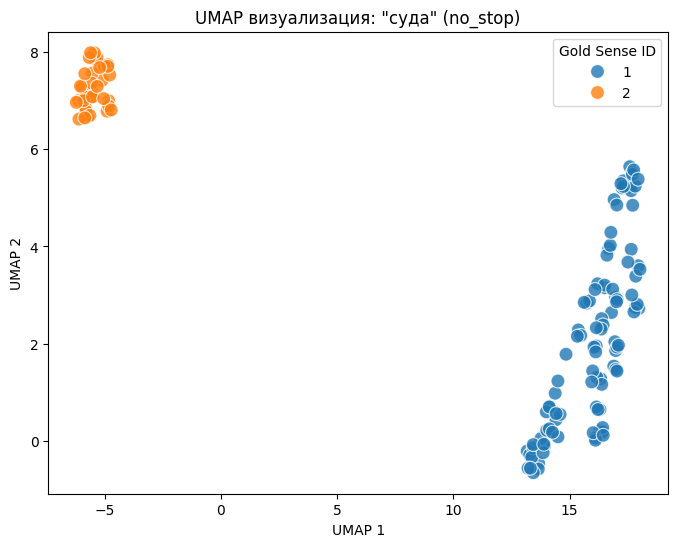

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


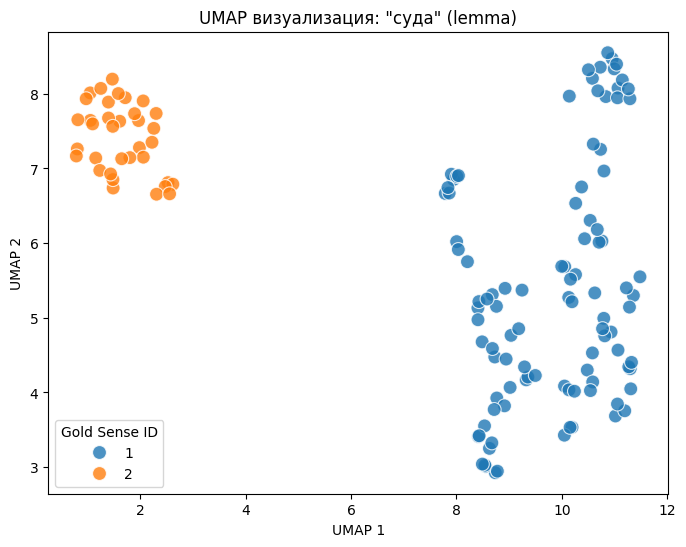

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import umap

embedding_types = ['clean', 'no_stop', 'lemma']

for word, group in df.groupby('word'):
    indices = group.index.tolist()

    for emb_name in embedding_types:
        embeddings = embeddings_dict[emb_name][indices]
        labels = group['gold_sense_id'].tolist()

        reducer = umap.UMAP(n_components=2, random_state=42)
        emb_2d = reducer.fit_transform(embeddings)

        plt.figure(figsize=(8,6))
        sns.scatterplot(
            x=emb_2d[:,0], y=emb_2d[:,1],
            hue=labels,
            palette='tab10',
            s=100,
            alpha=0.8
        )
        plt.title(f'UMAP визуализация: "{word}" ({emb_name})')
        plt.xlabel('UMAP 1')
        plt.ylabel('UMAP 2')
        plt.legend(title='Gold Sense ID')
        plt.show()


In [57]:
results_all = []

DBSCAN words:   0%|          | 0/4 [00:00<?, ?it/s]

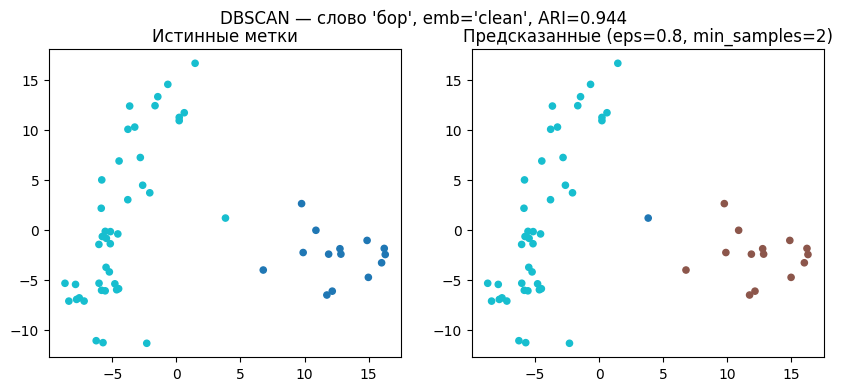

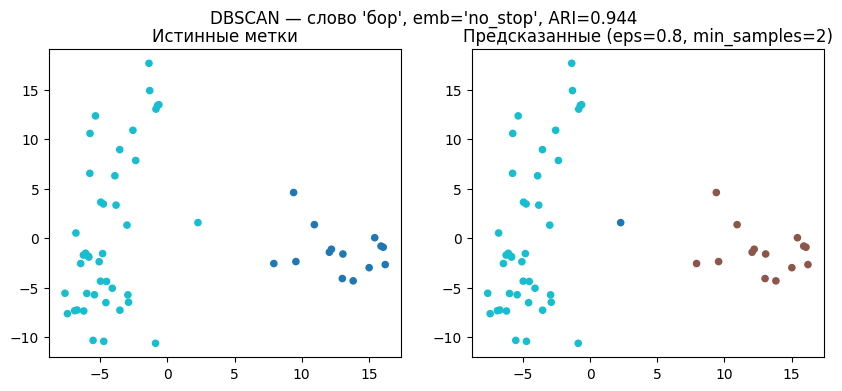

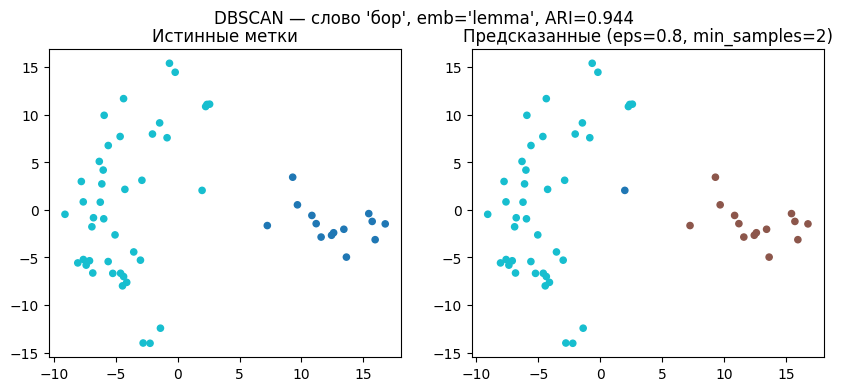

DBSCAN words:  25%|██▌       | 1/4 [00:01<00:04,  1.55s/it]

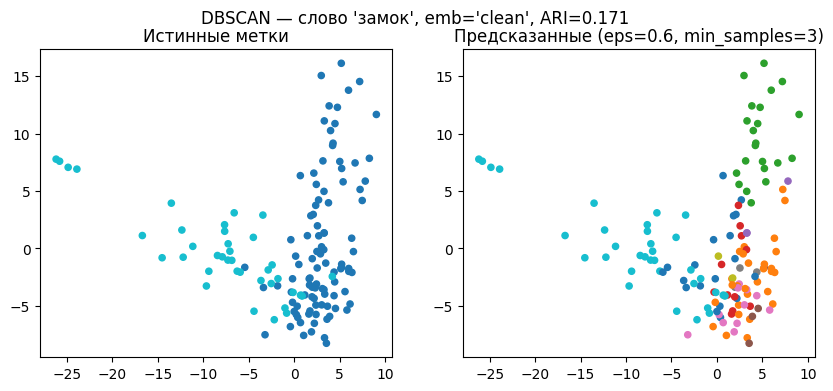

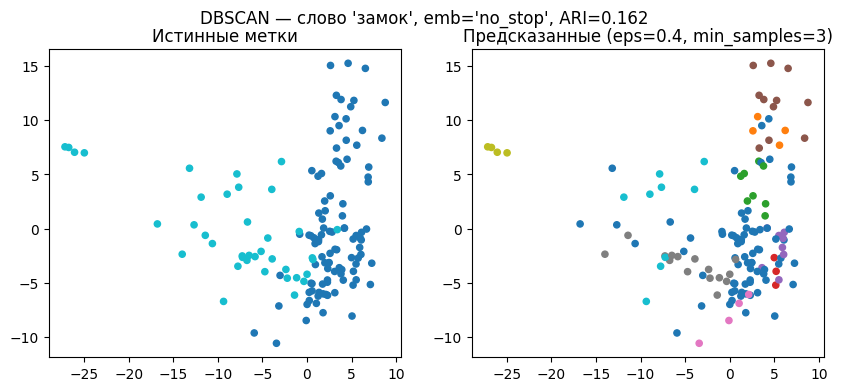

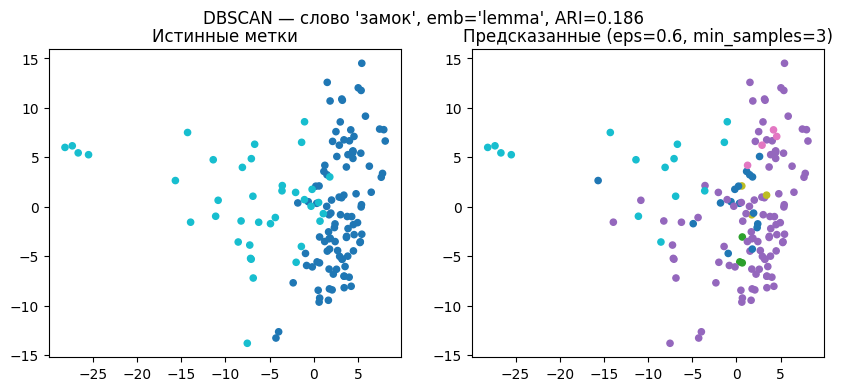

DBSCAN words:  50%|█████     | 2/4 [00:04<00:04,  2.09s/it]

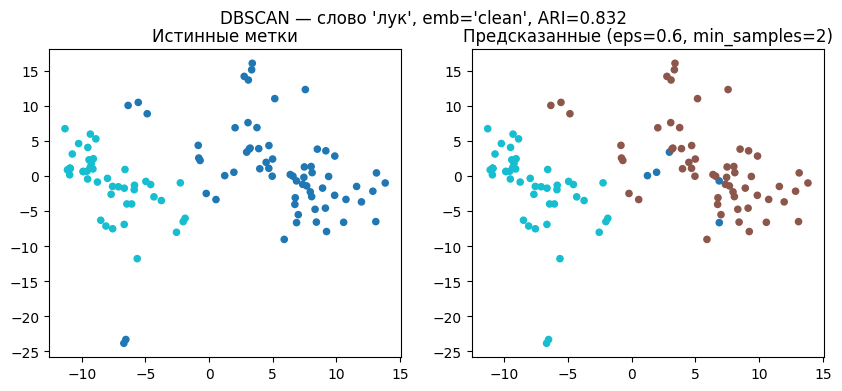

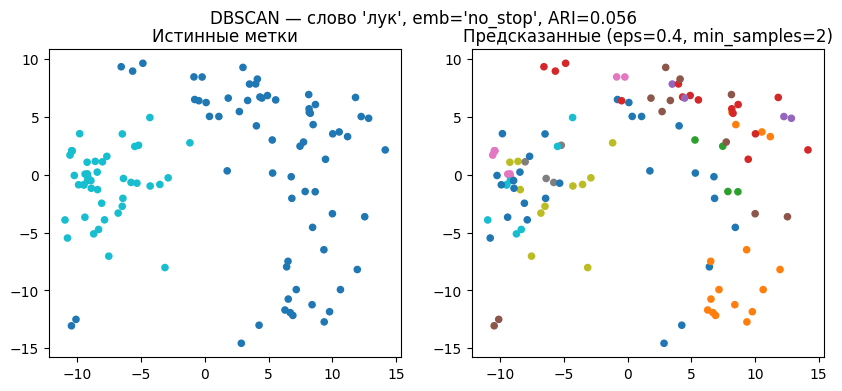

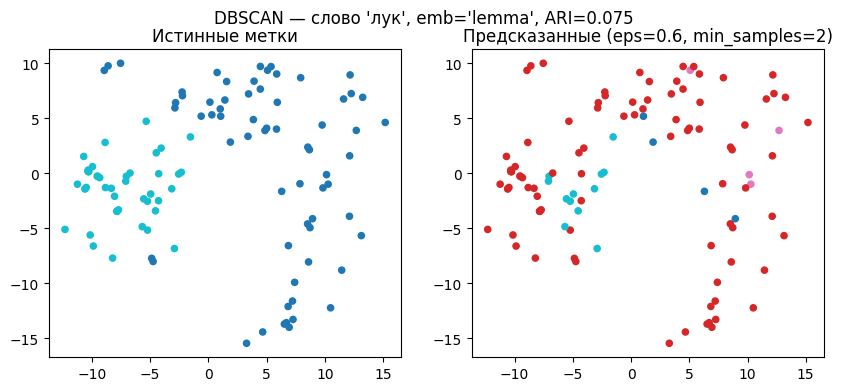

DBSCAN words:  75%|███████▌  | 3/4 [00:05<00:01,  1.70s/it]

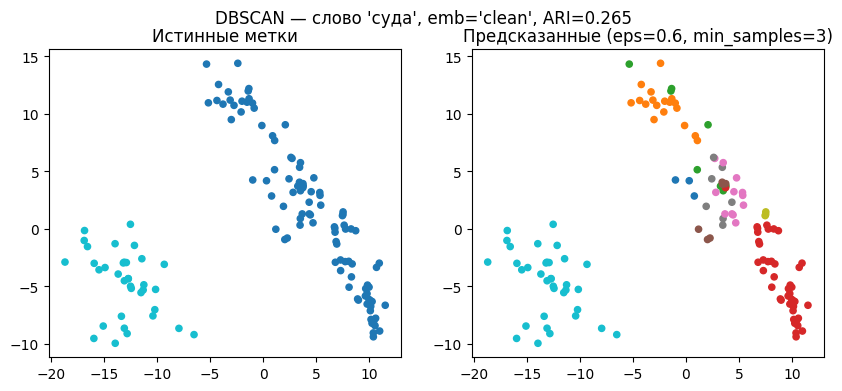

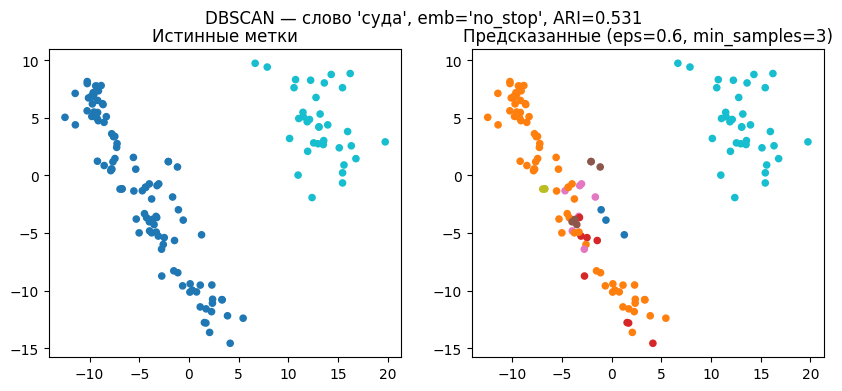

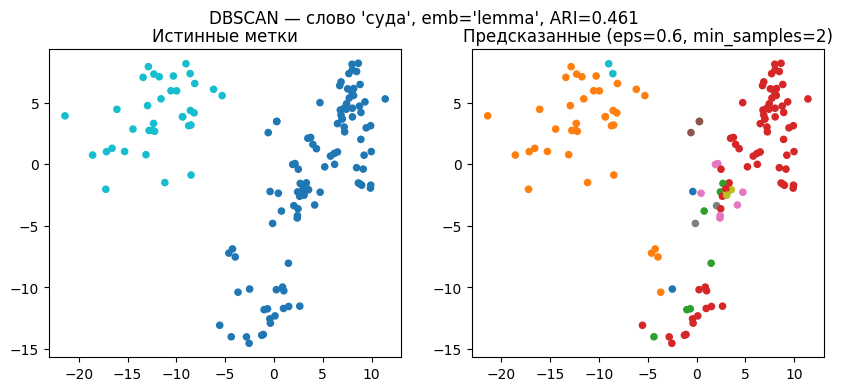

DBSCAN words: 100%|██████████| 4/4 [00:06<00:00,  1.56s/it]


In [58]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
from tqdm import tqdm

dbscan_eps_values = [0.2, 0.4, 0.6, 0.8]
dbscan_min_samples = [2,3]
dbscan_metrics = ['cosine', 'euclidean']

for word, group in tqdm(df.groupby('word'), desc="DBSCAN words"):
    gold_labels = group['gold_sense_id'].tolist()
    indices = group.index.tolist()

    for emb_name in embedding_types:
        embeddings = embeddings_dict[emb_name][indices]
        embeddings_scaled = StandardScaler().fit_transform(embeddings)

        best_ari = -1
        best_params = None
        best_pred = None

        for eps in dbscan_eps_values:
            for min_samples in dbscan_min_samples:
                for metric in dbscan_metrics:
                    db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
                    pred_labels = db.fit_predict(embeddings_scaled)
                    ari = adjusted_rand_score(gold_labels, pred_labels)
                    if ari > best_ari:
                        best_ari = ari
                        best_params = {'eps': eps, 'min_samples': min_samples, 'metric': metric}
                        best_pred = pred_labels

        results_all.append({
            'word': word,
            'embedding_type': emb_name,
            'method': 'DBSCAN',
            'best_ARI': best_ari,
            'best_params': best_params,
            'num_clusters': len(set(best_pred)) - (1 if -1 in best_pred else 0)
        })

        # === Визуализация лучших результатов ===
        if best_pred is not None and len(set(best_pred)) > 1:
            pca = PCA(n_components=2, random_state=42)
            reduced = pca.fit_transform(embeddings_scaled)

            fig, axs = plt.subplots(1, 2, figsize=(10, 4))
            fig.suptitle(f"DBSCAN — слово '{word}', emb='{emb_name}', ARI={best_ari:.3f}", fontsize=12)

            # Реальные метки
            axs[0].scatter(reduced[:,0], reduced[:,1], c=gold_labels, cmap='tab10', s=20)
            axs[0].set_title("Истинные метки")

            # Предсказанные метки
            axs[1].scatter(reduced[:,0], reduced[:,1], c=best_pred, cmap='tab10', s=20)
            axs[1].set_title(f"Предсказанные (eps={best_params['eps']}, min_samples={best_params['min_samples']})")

            plt.show()


AffinityPropagation words:   0%|          | 0/4 [00:00<?, ?it/s]

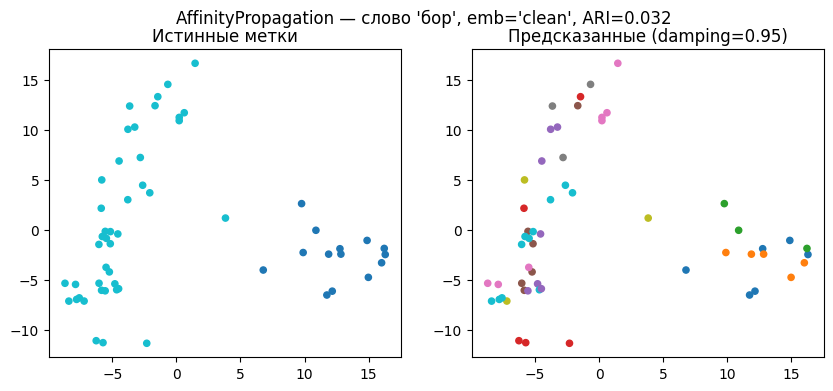

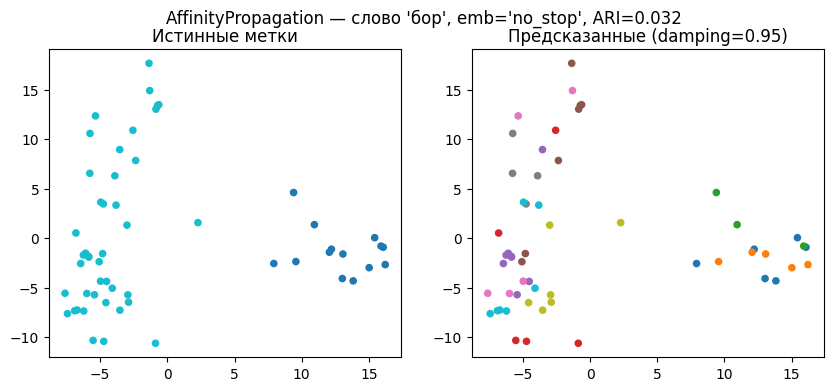

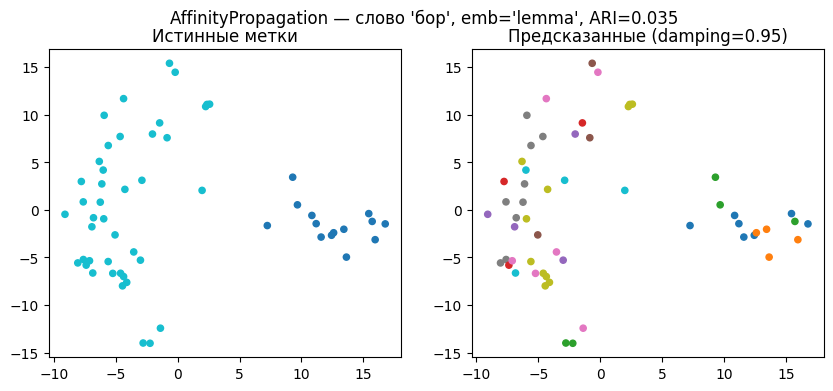

AffinityPropagation words:  25%|██▌       | 1/4 [00:02<00:06,  2.04s/it]

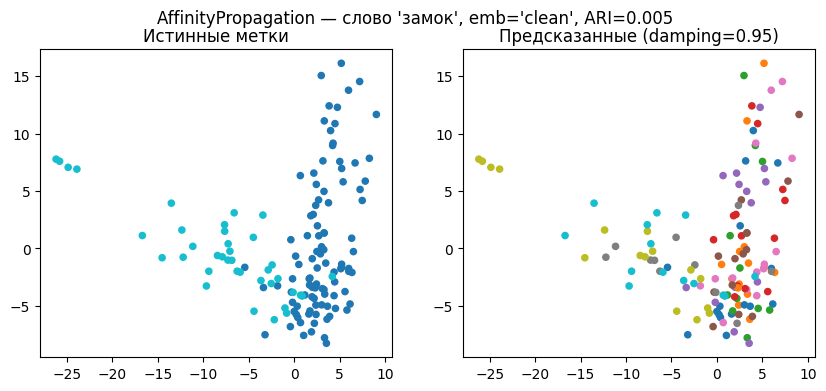

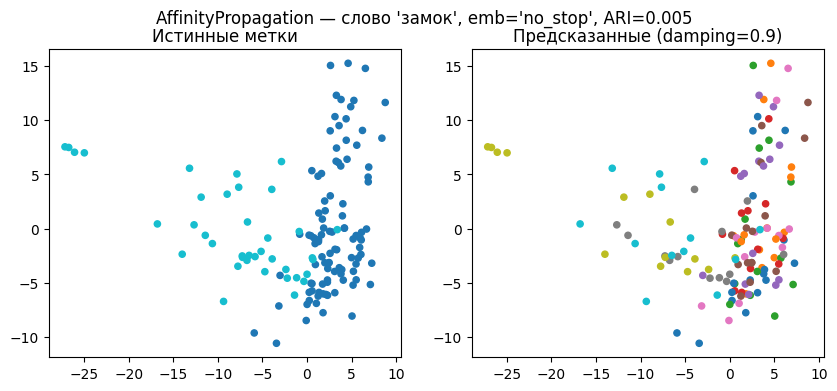

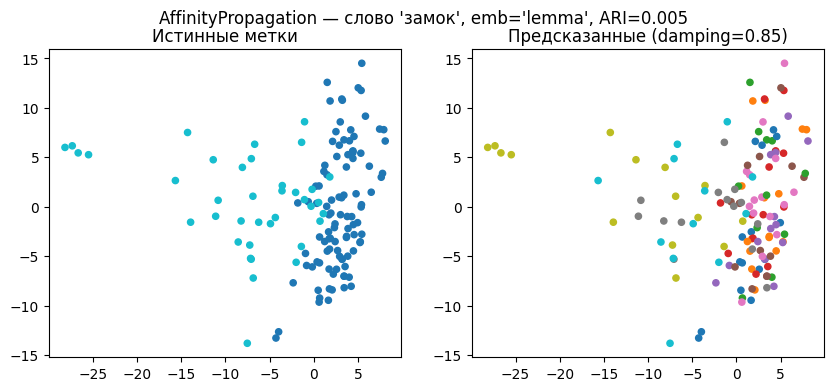

AffinityPropagation words:  50%|█████     | 2/4 [00:04<00:04,  2.11s/it]

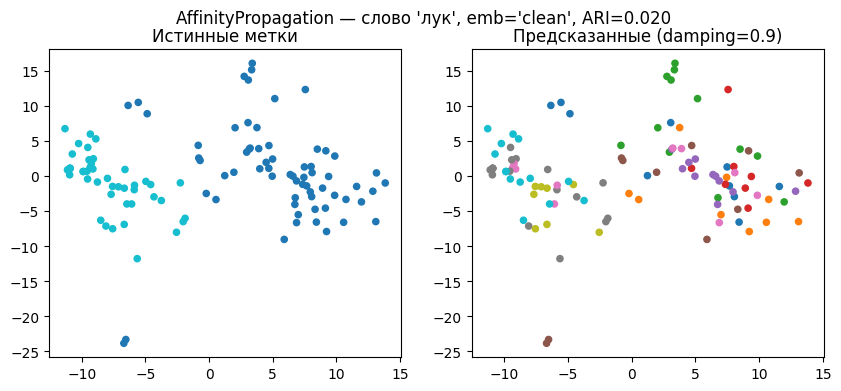

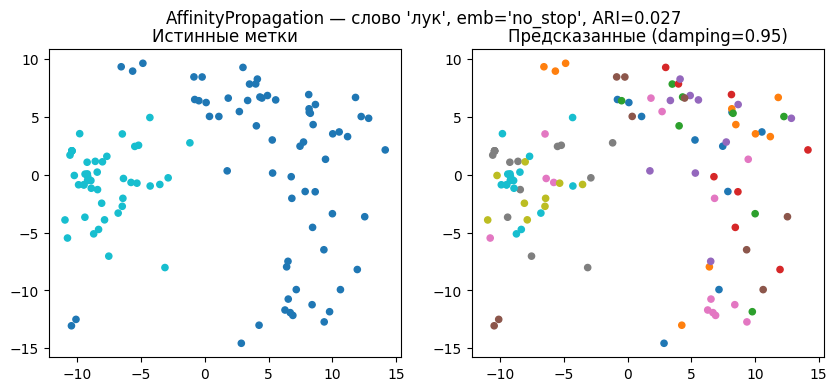

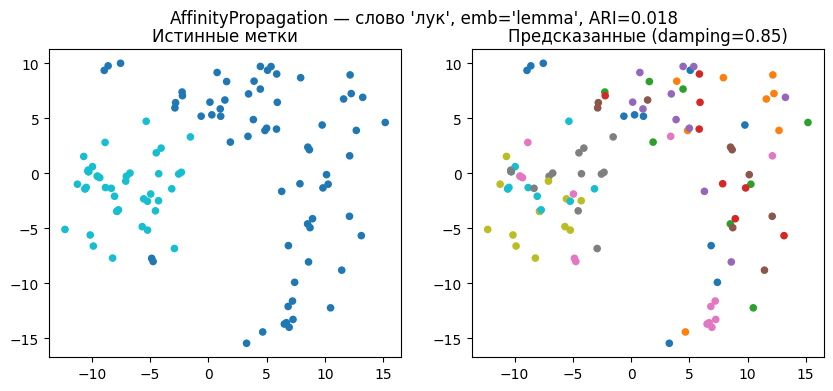

AffinityPropagation words:  75%|███████▌  | 3/4 [00:06<00:02,  2.34s/it]

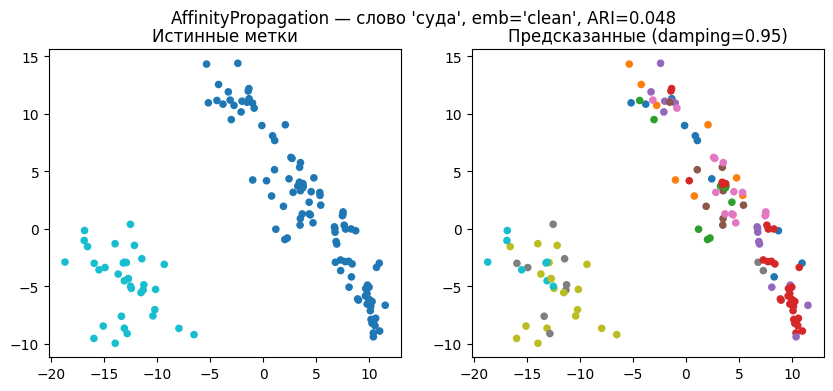

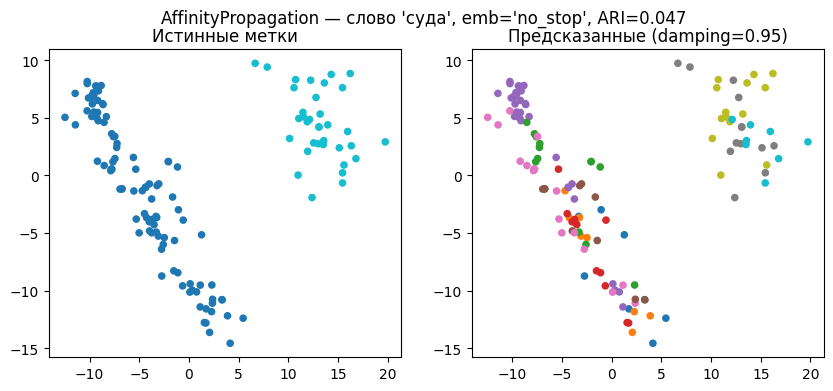

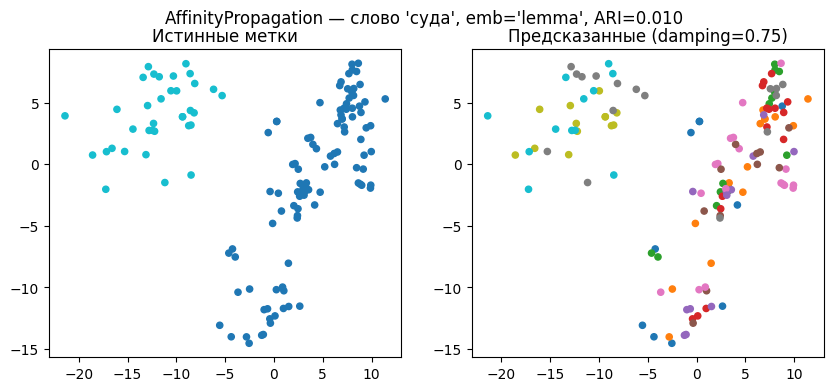

AffinityPropagation words: 100%|██████████| 4/4 [00:08<00:00,  2.02s/it]


In [59]:
from sklearn.cluster import AffinityPropagation
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

ap_damping_values = [0.75, 0.8, 0.85, 0.9, 0.95]

for word, group in tqdm(df.groupby('word'), desc="AffinityPropagation words"):
    gold_labels = group['gold_sense_id'].tolist()
    indices = group.index.tolist()

    for emb_name in embedding_types:
        embeddings = embeddings_dict[emb_name][indices]
        embeddings_scaled = StandardScaler().fit_transform(embeddings)

        # Снижение размерности через PCA
        n_components = min(20, embeddings_scaled.shape[0])
        embeddings_reduced = PCA(n_components=n_components, random_state=42).fit_transform(embeddings_scaled)

        best_ari = -1
        best_params = None
        best_pred = None

        # Динамический выбор preference по медиане сходств
        similarity = -np.linalg.norm(embeddings_reduced[:, None] - embeddings_reduced[None, :], axis=2)
        preference = np.median(similarity)

        for damping in ap_damping_values:
            try:
                ap = AffinityPropagation(damping=damping, preference=preference, random_state=42)
                pred_labels = ap.fit_predict(embeddings_reduced)
                ari = adjusted_rand_score(gold_labels, pred_labels)

                if ari > best_ari:
                    best_ari = ari
                    best_params = {'damping': damping, 'preference': preference}
                    best_pred = pred_labels
            except Exception:
                continue

        results_all.append({
            'word': word,
            'embedding_type': emb_name,
            'method': 'AffinityPropagation',
            'best_ARI': best_ari,
            'best_params': best_params,
            'num_clusters': len(set(best_pred)) if best_pred is not None else 0
        })

        # === Визуализация лучших результатов ===
        if best_pred is not None and len(set(best_pred)) > 1:
            pca = PCA(n_components=2, random_state=42)
            reduced = pca.fit_transform(embeddings_scaled)

            fig, axs = plt.subplots(1, 2, figsize=(10, 4))
            fig.suptitle(f"AffinityPropagation — слово '{word}', emb='{emb_name}', ARI={best_ari:.3f}", fontsize=12)

            # Реальные метки
            axs[0].scatter(reduced[:,0], reduced[:,1], c=gold_labels, cmap='tab10', s=20)
            axs[0].set_title("Истинные метки")

            # Предсказанные метки
            axs[1].scatter(reduced[:,0], reduced[:,1], c=best_pred, cmap='tab10', s=20)
            axs[1].set_title(f"Предсказанные (damping={best_params['damping']})")

            plt.show()


Agglomerative words:   0%|          | 0/4 [00:00<?, ?it/s]

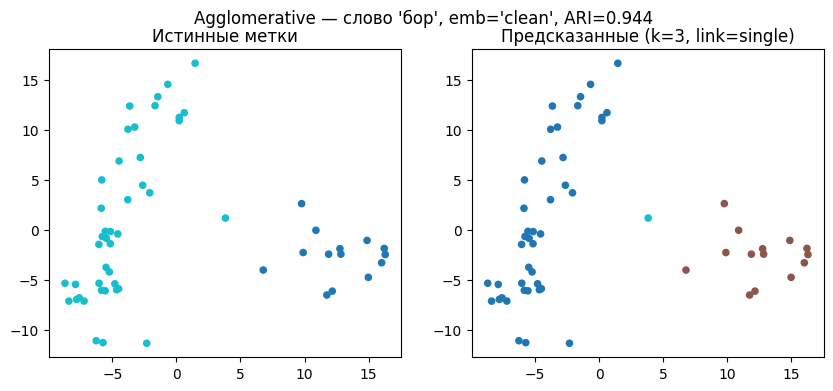

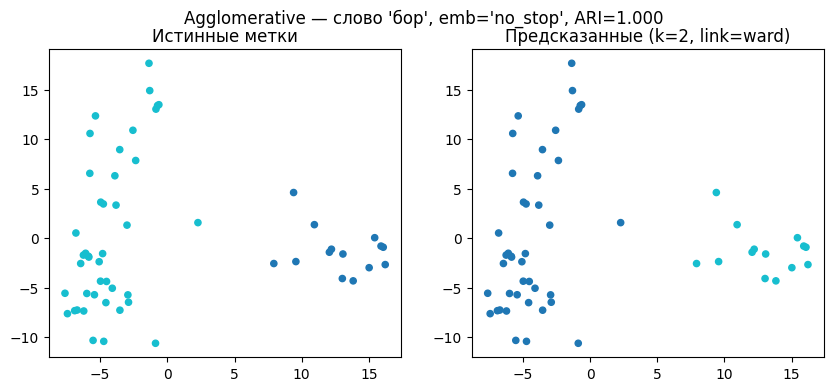

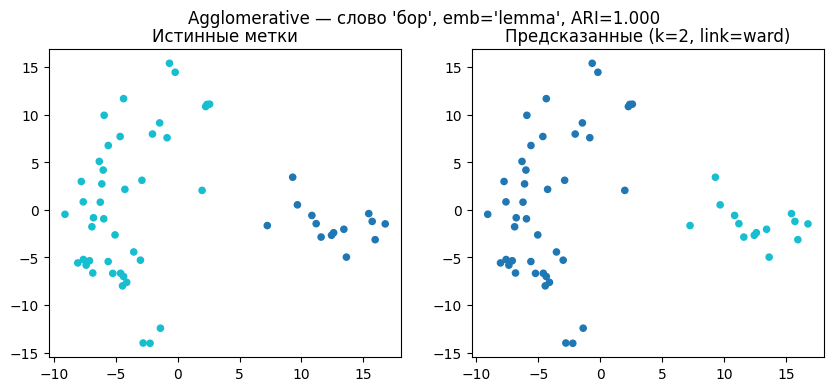

Agglomerative words:  25%|██▌       | 1/4 [00:02<00:06,  2.00s/it]

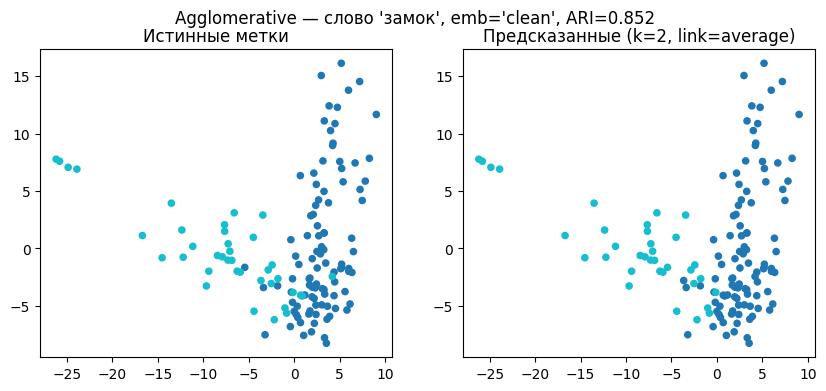

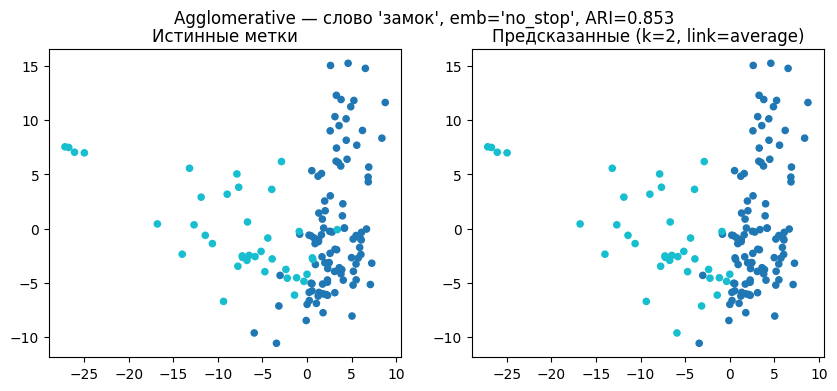

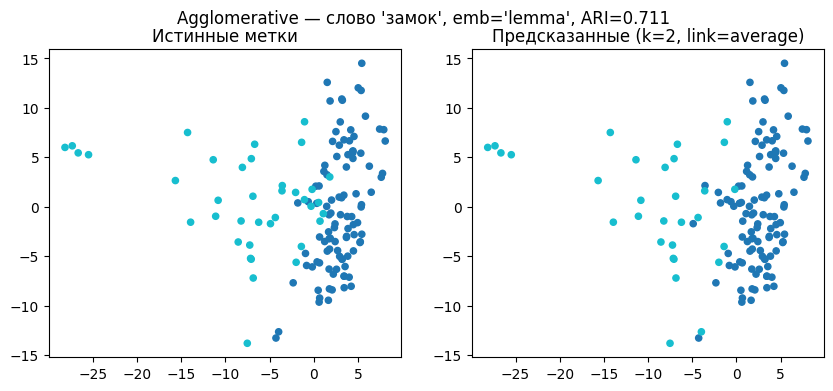

Agglomerative words:  50%|█████     | 2/4 [00:06<00:07,  3.51s/it]

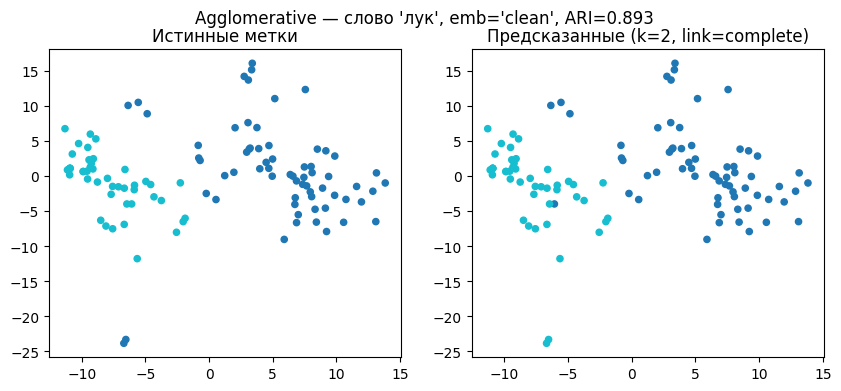

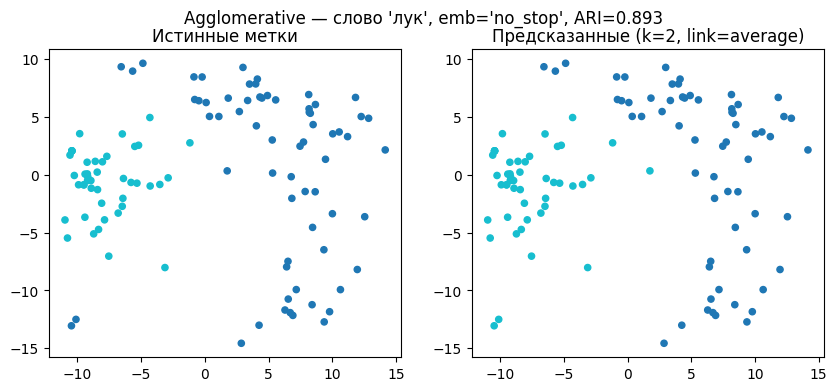

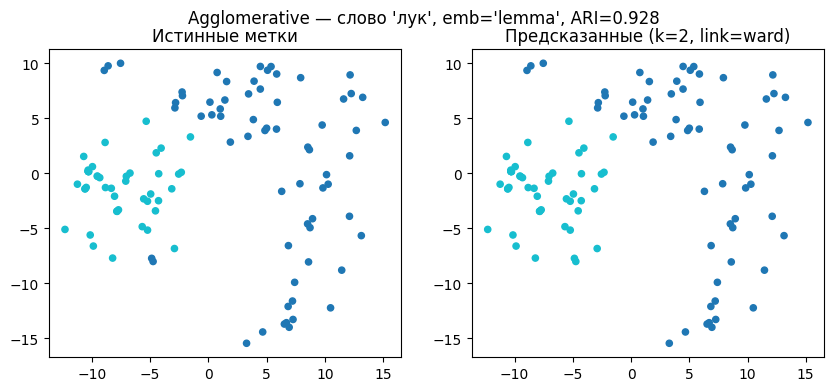

Agglomerative words:  75%|███████▌  | 3/4 [00:07<00:02,  2.36s/it]

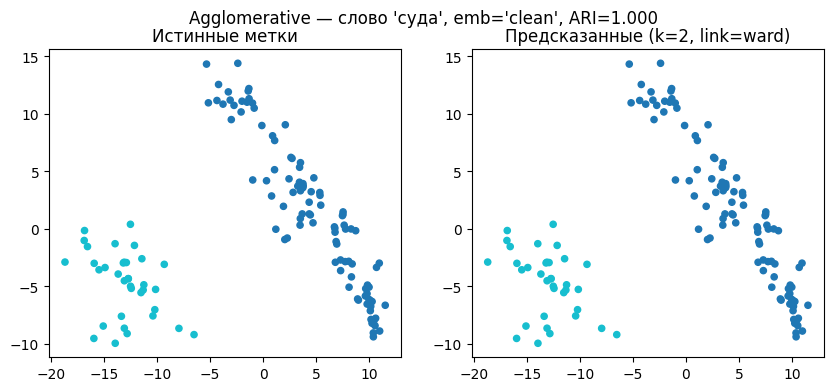

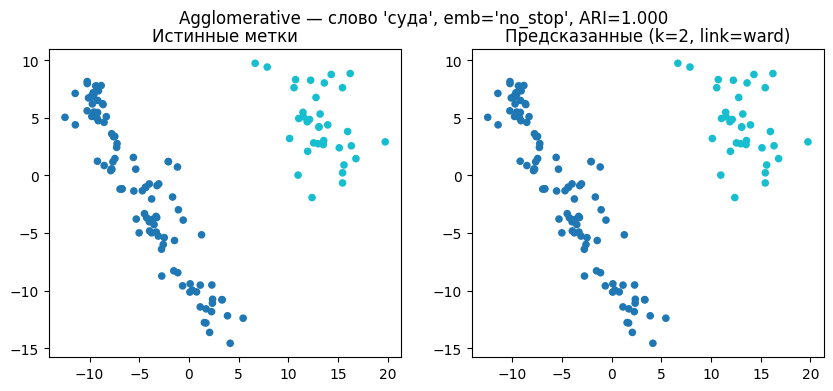

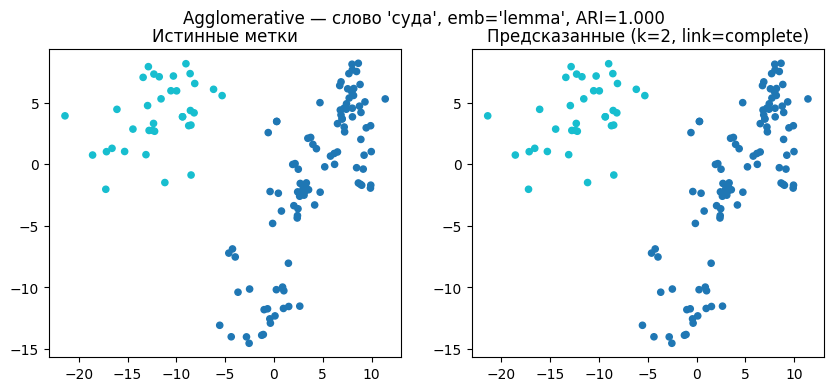

Agglomerative words: 100%|██████████| 4/4 [00:08<00:00,  2.15s/it]


In [60]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt

agglo_n_clusters = [2,3,4,5]
agglo_metrics = ['euclidean', 'cosine']
agglo_linkage = ['ward','complete','average','single']

for word, group in tqdm(df.groupby('word'), desc="Agglomerative words"):
    gold_labels = group['gold_sense_id'].tolist()
    indices = group.index.tolist()

    for emb_name in embedding_types:
        embeddings = embeddings_dict[emb_name][indices]
        embeddings_scaled = StandardScaler().fit_transform(embeddings)

        best_ari = -1
        best_params = None
        best_pred = None

        for n_clusters in agglo_n_clusters:
            for metric in agglo_metrics:
                for linkage in agglo_linkage:
                    if linkage == 'ward' and metric != 'euclidean':
                        continue
                    try:
                        ag = AgglomerativeClustering(
                            n_clusters=n_clusters,
                            metric=metric,
                            linkage=linkage
                        )
                        pred_labels = ag.fit_predict(embeddings_scaled)
                        ari = adjusted_rand_score(gold_labels, pred_labels)
                        if ari > best_ari:
                            best_ari = ari
                            best_params = {
                                'n_clusters': n_clusters,
                                'metric': metric,
                                'linkage': linkage
                            }
                            best_pred = pred_labels
                    except Exception:
                        continue

        results_all.append({
            'word': word,
            'embedding_type': emb_name,
            'method': 'AgglomerativeClustering',
            'best_ARI': best_ari,
            'best_params': best_params,
            'num_clusters': len(set(best_pred)) if best_pred is not None else 0
        })

        # === Визуализация лучших результатов ===
        if best_pred is not None and len(set(best_pred)) > 1:
            pca = PCA(n_components=2, random_state=42)
            reduced = pca.fit_transform(embeddings_scaled)

            fig, axs = plt.subplots(1, 2, figsize=(10, 4))
            fig.suptitle(
                f"Agglomerative — слово '{word}', emb='{emb_name}', ARI={best_ari:.3f}",
                fontsize=12
            )

            # Истинные метки
            axs[0].scatter(reduced[:,0], reduced[:,1], c=gold_labels, cmap='tab10', s=20)
            axs[0].set_title("Истинные метки")

            # Предсказанные метки
            axs[1].scatter(reduced[:,0], reduced[:,1], c=best_pred, cmap='tab10', s=20)
            axs[1].set_title(f"Предсказанные (k={best_params['n_clusters']}, link={best_params['linkage']})")

            plt.show()


KMeans words:   0%|          | 0/4 [00:00<?, ?it/s]

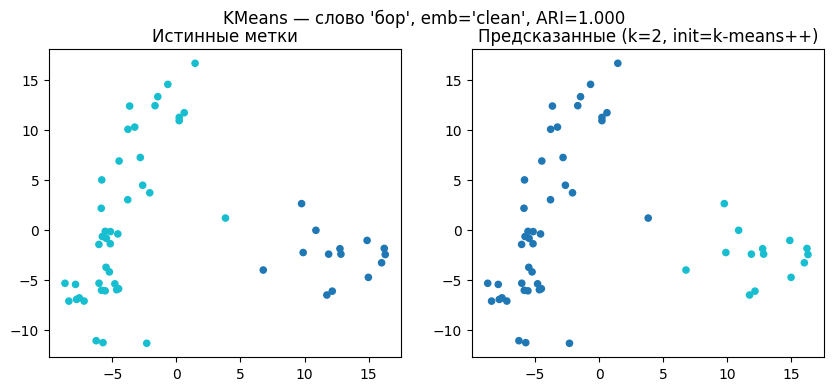

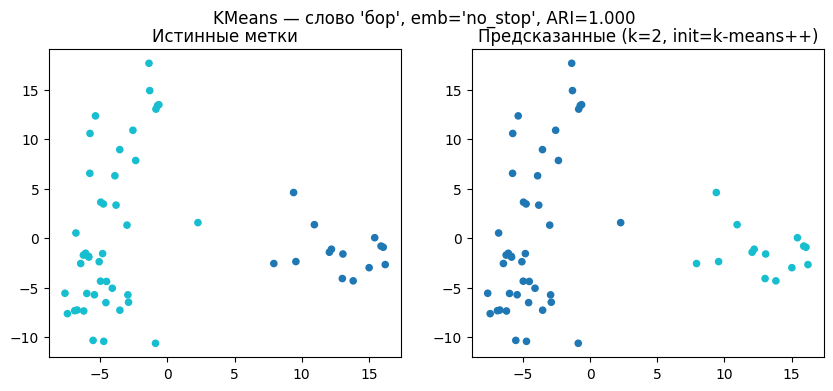

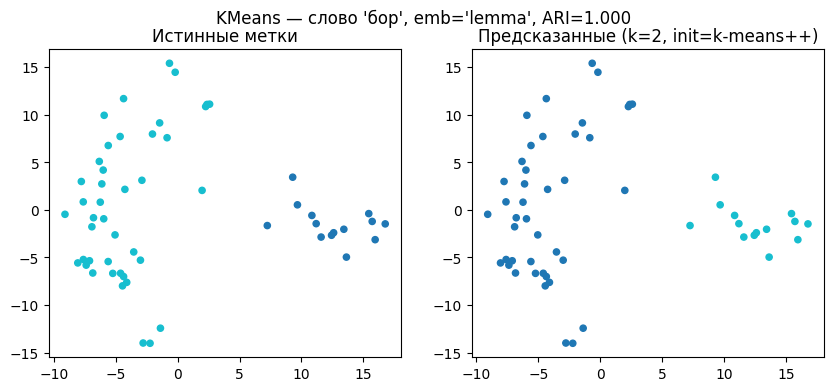

KMeans words:  25%|██▌       | 1/4 [00:14<00:43, 14.59s/it]

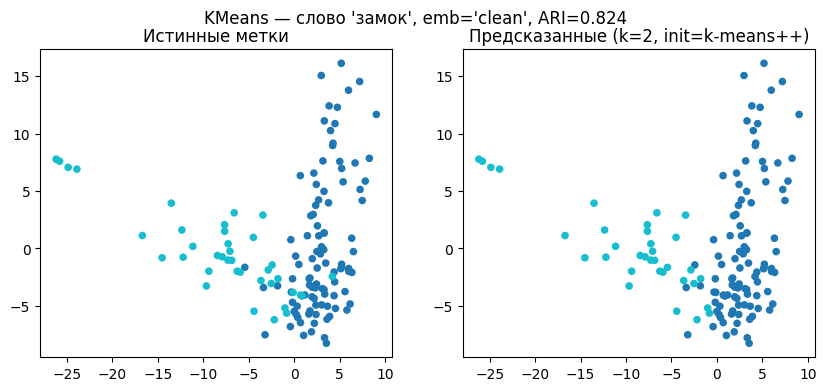

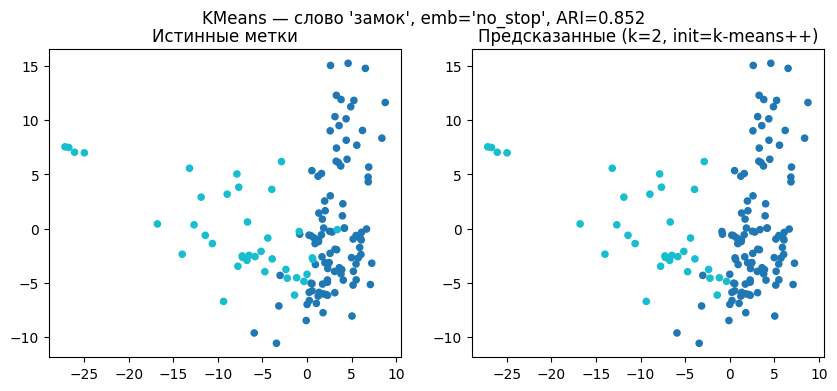

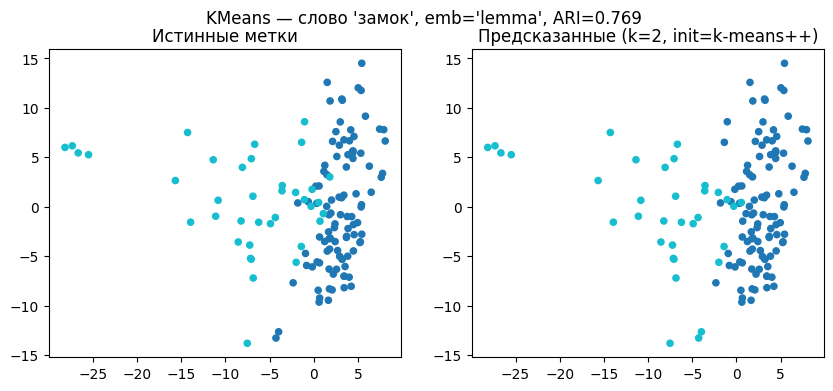

KMeans words:  50%|█████     | 2/4 [00:34<00:34, 17.47s/it]

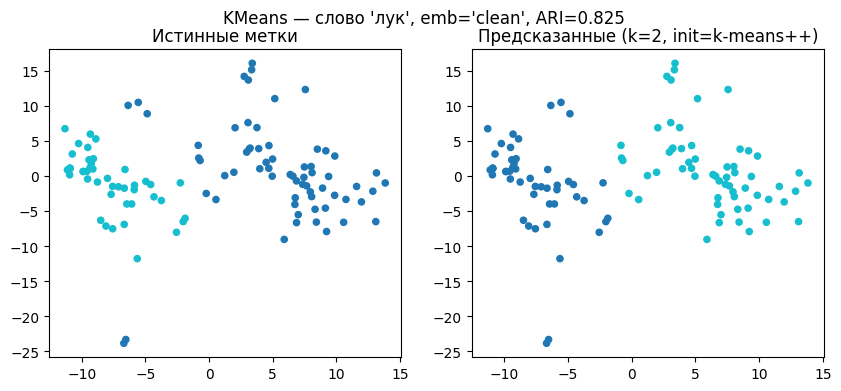

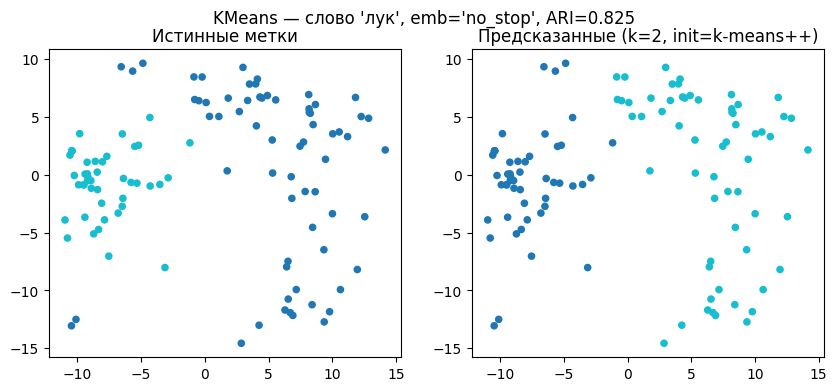

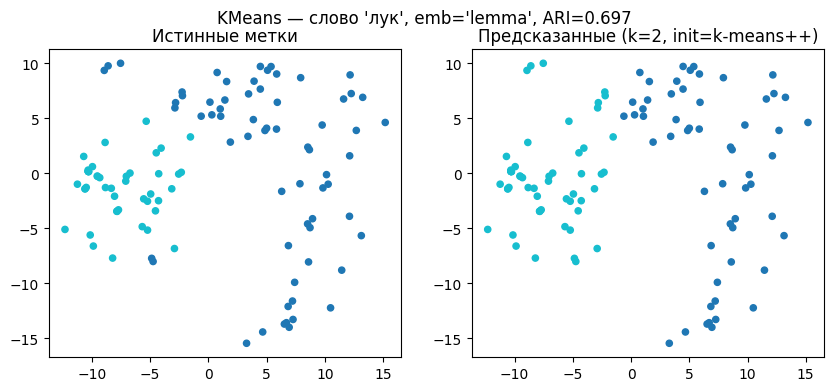

KMeans words:  75%|███████▌  | 3/4 [00:50<00:17, 17.16s/it]

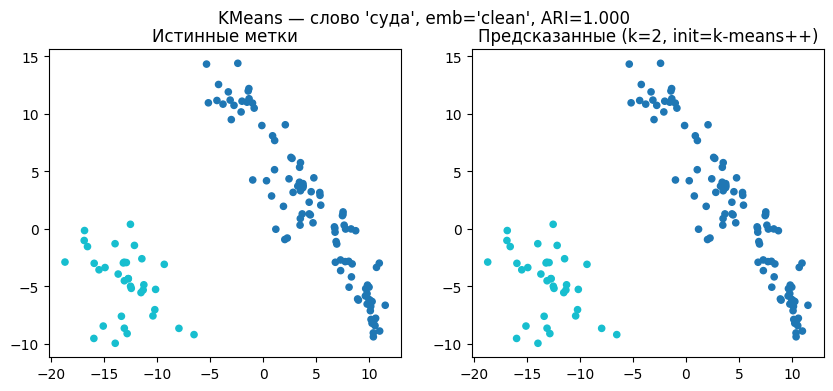

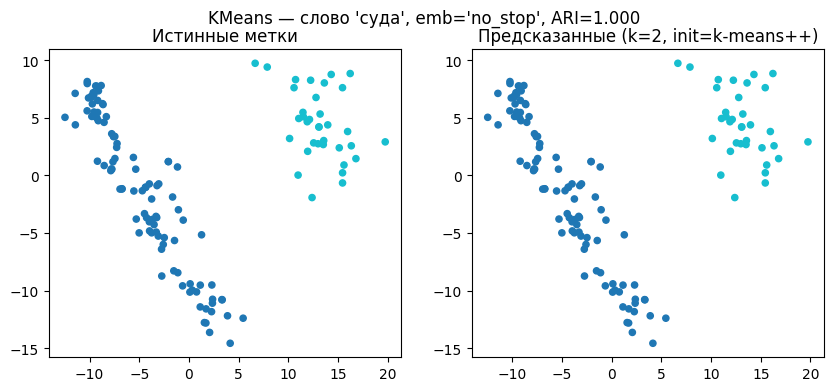

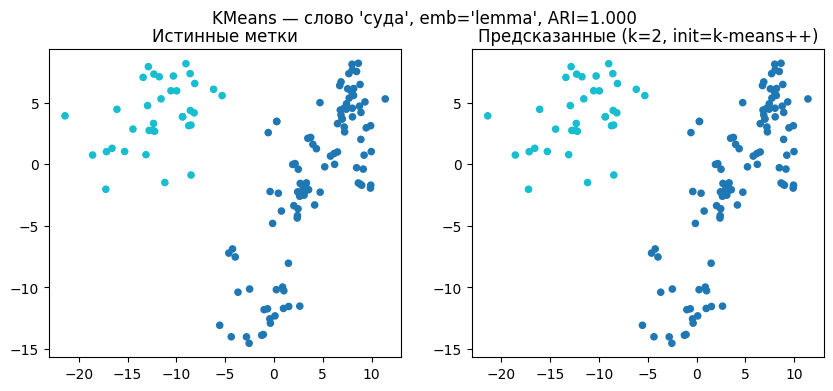

KMeans words: 100%|██████████| 4/4 [01:07<00:00, 16.93s/it]


In [61]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt

kmeans_n_clusters = [2,3,4,5]
kmeans_init = ['k-means++','random']
kmeans_n_init = [10,20]
kmeans_max_iter = [300,500]
kmeans_tol = [1e-4,1e-3]
kmeans_algorithm = ['lloyd','elkan']

for word, group in tqdm(df.groupby('word'), desc="KMeans words"):
    gold_labels = group['gold_sense_id'].tolist()
    indices = group.index.tolist()

    for emb_name in embedding_types:
        embeddings = embeddings_dict[emb_name][indices]
        embeddings_scaled = StandardScaler().fit_transform(embeddings)

        best_ari = -1
        best_params = None
        best_pred = None

        for n_clusters in kmeans_n_clusters:
            for init in kmeans_init:
                for n_init in kmeans_n_init:
                    for max_iter_val in kmeans_max_iter:
                        for tol in kmeans_tol:
                            for algorithm in kmeans_algorithm:
                                try:
                                    km = KMeans(
                                        n_clusters=n_clusters,
                                        init=init,
                                        n_init=n_init,
                                        max_iter=max_iter_val,
                                        tol=tol,
                                        algorithm=algorithm,
                                        random_state=42
                                    )
                                    pred_labels = km.fit_predict(embeddings_scaled)
                                    ari = adjusted_rand_score(gold_labels, pred_labels)
                                    if ari > best_ari:
                                        best_ari = ari
                                        best_params = {
                                            'n_clusters': n_clusters,
                                            'init': init,
                                            'n_init': n_init,
                                            'max_iter': max_iter_val,
                                            'tol': tol,
                                            'algorithm': algorithm
                                        }
                                        best_pred = pred_labels
                                except Exception:
                                    continue

        results_all.append({
            'word': word,
            'embedding_type': emb_name,
            'method': 'KMeans',
            'best_ARI': best_ari,
            'best_params': best_params,
            'num_clusters': len(set(best_pred)) if best_pred is not None else 0
        })

        # === Визуализация лучших результатов ===
        if best_pred is not None and len(set(best_pred)) > 1:
            pca = PCA(n_components=2, random_state=42)
            reduced = pca.fit_transform(embeddings_scaled)

            fig, axs = plt.subplots(1, 2, figsize=(10, 4))
            fig.suptitle(
                f"KMeans — слово '{word}', emb='{emb_name}', ARI={best_ari:.3f}",
                fontsize=12
            )

            # Истинные метки
            axs[0].scatter(reduced[:,0], reduced[:,1], c=gold_labels, cmap='tab10', s=20)
            axs[0].set_title("Истинные метки")

            # Предсказанные метки
            axs[1].scatter(reduced[:,0], reduced[:,1], c=best_pred, cmap='tab10', s=20)
            axs[1].set_title(f"Предсказанные (k={best_params['n_clusters']}, init={best_params['init']})")

            plt.show()


**Gaussian Mixture Model** — это вероятностная модель, которая предполагает, что данные сгенерированы смесью нескольких многомерных нормальных распределений.
Каждый кластер описывается своим гауссовским распределением. То есть модель пытается нарисовать несколько гауссиан так, чтобы вместе они лучше всего описывали точки. Каждая точка будет тяготеть к каждому колоколу с определённой вероятностью. Преимуществум будет то что кластеры могут иметь вытенутую форму.

GMM words:   0%|          | 0/4 [00:00<?, ?it/s]

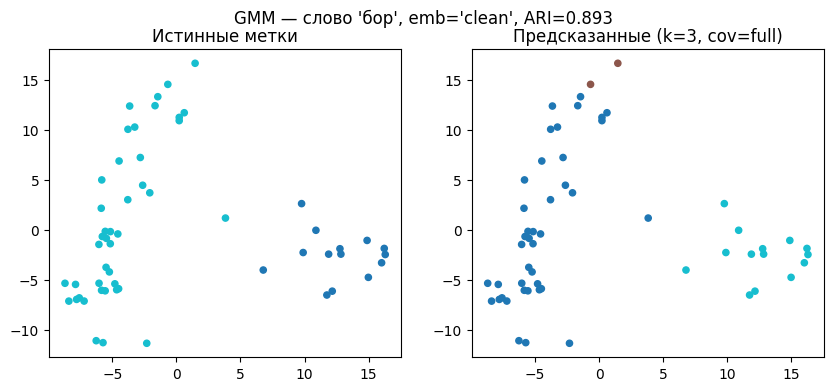

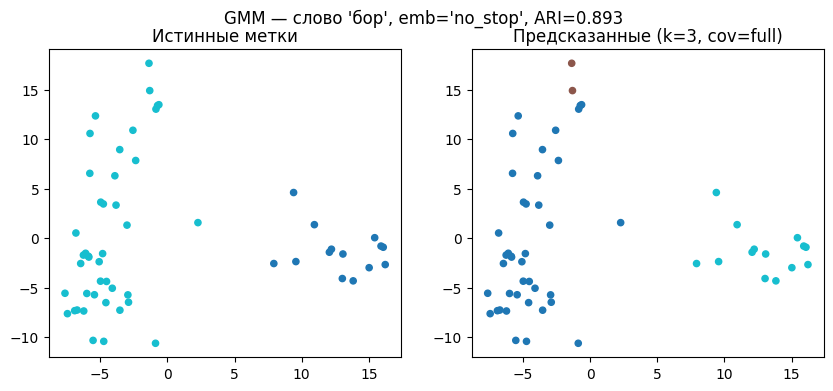

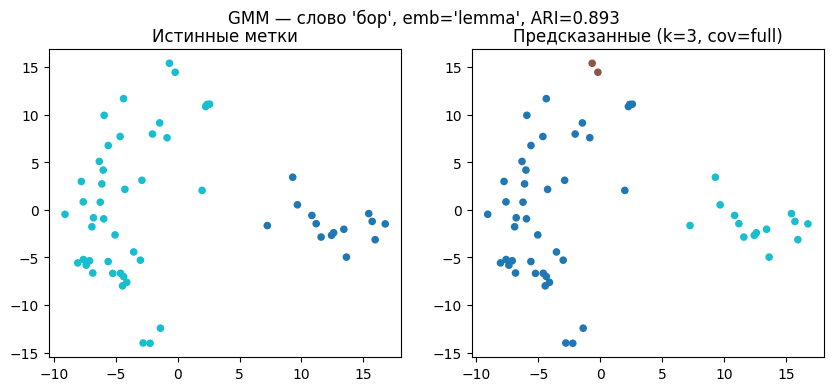

GMM words:  25%|██▌       | 1/4 [00:51<02:34, 51.52s/it]

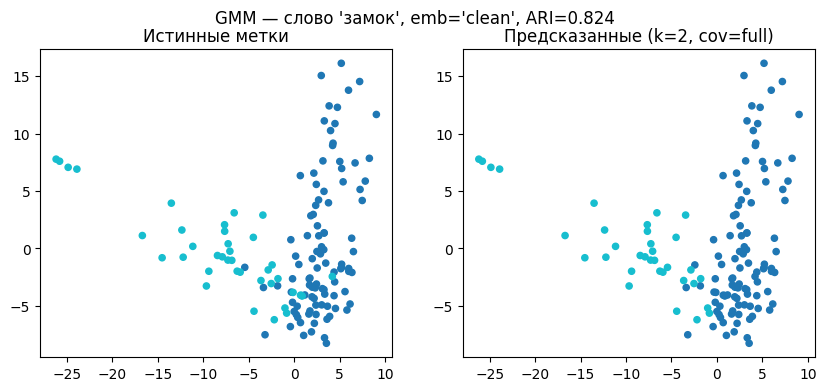

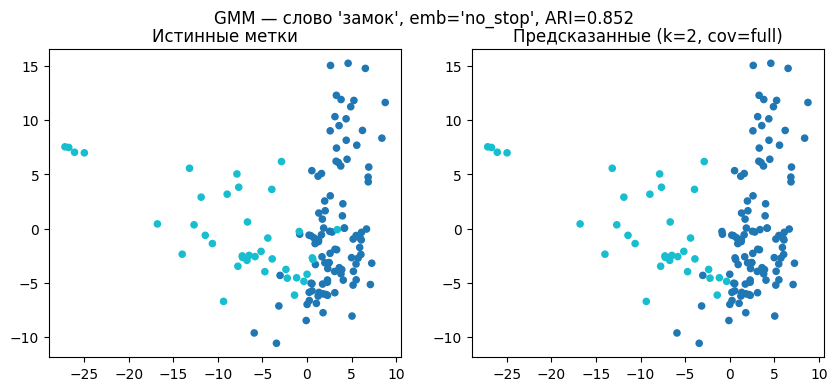

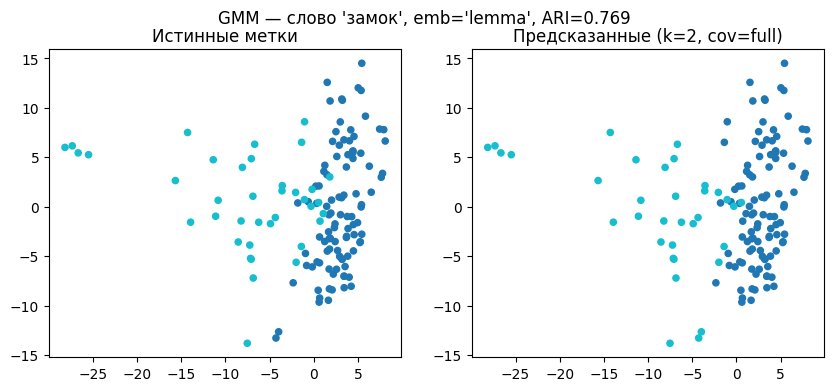

GMM words:  50%|█████     | 2/4 [01:47<01:47, 53.92s/it]

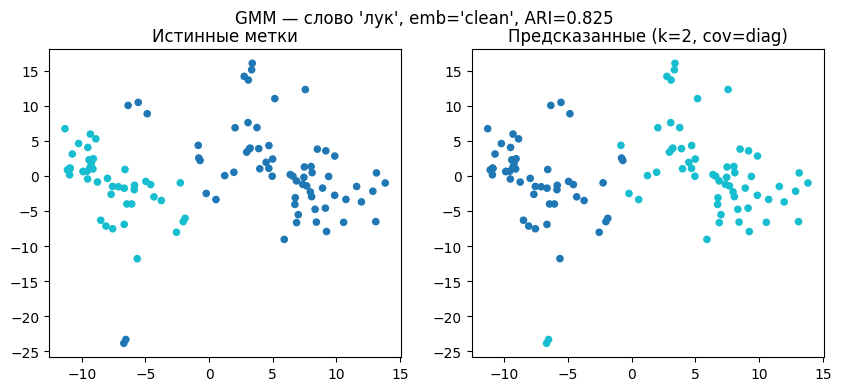

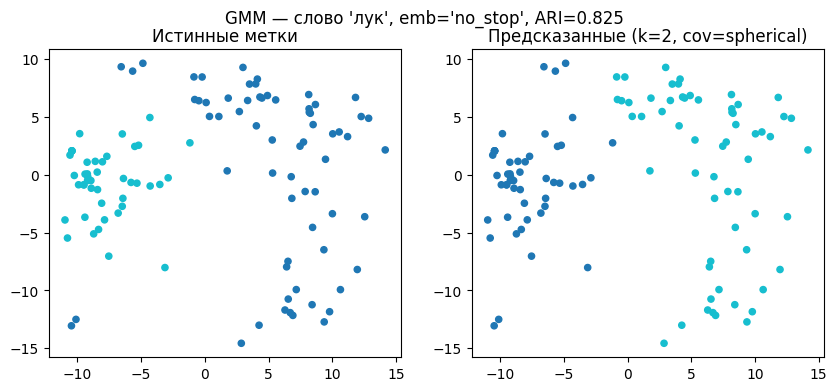

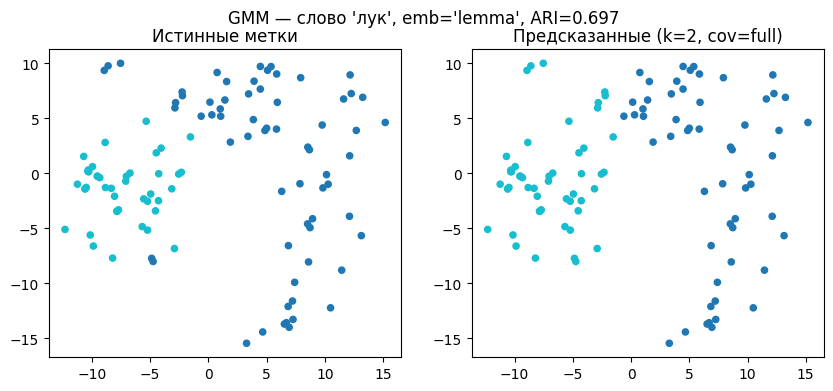

GMM words:  75%|███████▌  | 3/4 [02:32<00:50, 50.14s/it]

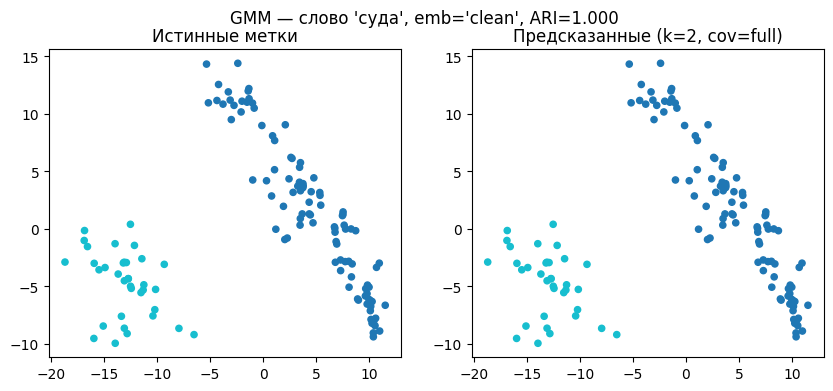

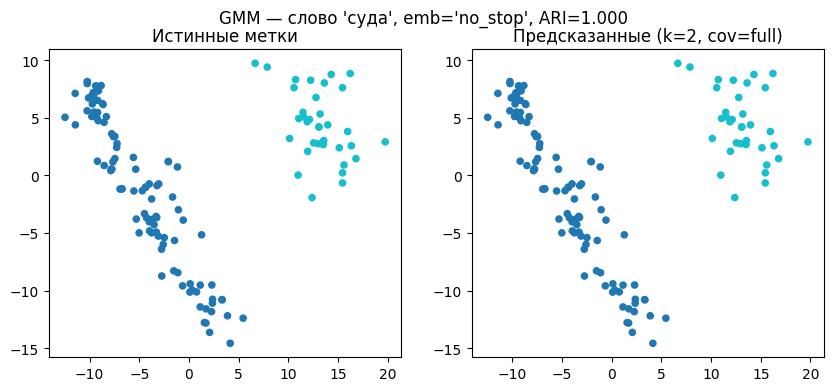

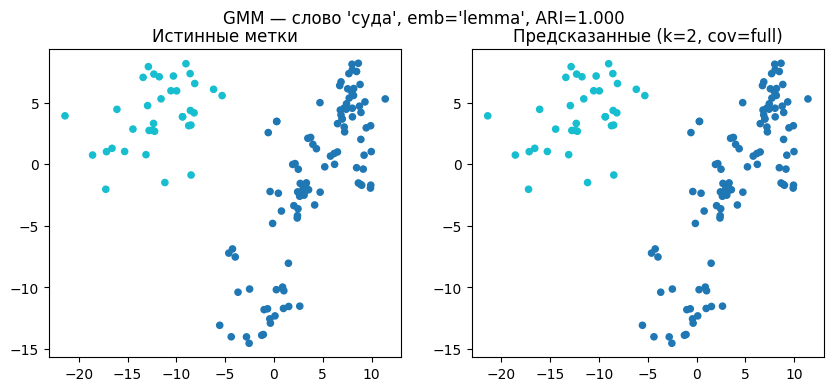

GMM words: 100%|██████████| 4/4 [03:19<00:00, 49.98s/it]


In [62]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt

gmm_n_components = [2,3,4,5]
gmm_covariance_type = ['full','tied','diag','spherical']
gmm_init_params = ['kmeans','random']
gmm_max_iter = [100,200]

for word, group in tqdm(df.groupby('word'), desc="GMM words"):
    gold_labels = group['gold_sense_id'].tolist()
    indices = group.index.tolist()

    for emb_name in embedding_types:
        embeddings = embeddings_dict[emb_name][indices]
        embeddings_scaled = StandardScaler().fit_transform(embeddings)

        best_ari = -1
        best_params = None
        best_pred = None

        max_components = min(len(indices), max(gmm_n_components))

        for n_components in [c for c in gmm_n_components if c <= max_components]:
            for cov_type in gmm_covariance_type:
                for init_param in gmm_init_params:
                    for max_iter_val in gmm_max_iter:
                        try:
                            gmm = GaussianMixture(
                                n_components=n_components,
                                covariance_type=cov_type,
                                init_params=init_param,
                                max_iter=max_iter_val,
                                random_state=42,
                                reg_covar=1e-5
                            )
                            pred_labels = gmm.fit_predict(embeddings_scaled)
                            ari = adjusted_rand_score(gold_labels, pred_labels)
                            if ari > best_ari:
                                best_ari = ari
                                best_params = {
                                    'n_components': n_components,
                                    'covariance_type': cov_type,
                                    'init_params': init_param,
                                    'max_iter': max_iter_val
                                }
                                best_pred = pred_labels
                        except Exception:
                            continue

        results_all.append({
            'word': word,
            'embedding_type': emb_name,
            'method': 'GMM',
            'best_ARI': best_ari,
            'best_params': best_params,
            'num_clusters': len(set(best_pred)) if best_pred is not None else 0
        })

        # === Визуализация лучших результатов ===
        if best_pred is not None and len(set(best_pred)) > 1:
            pca = PCA(n_components=2, random_state=42)
            reduced = pca.fit_transform(embeddings_scaled)

            fig, axs = plt.subplots(1, 2, figsize=(10, 4))
            fig.suptitle(
                f"GMM — слово '{word}', emb='{emb_name}', ARI={best_ari:.3f}",
                fontsize=12
            )

            # Истинные метки
            axs[0].scatter(reduced[:,0], reduced[:,1], c=gold_labels, cmap='tab10', s=20)
            axs[0].set_title("Истинные метки")

            # Предсказанные метки
            axs[1].scatter(reduced[:,0], reduced[:,1], c=best_pred, cmap='tab10', s=20)
            axs[1].set_title(
                f"Предсказанные (k={best_params['n_components']}, cov={best_params['covariance_type']})"
            )

            plt.show()


In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

results_df = pd.DataFrame(results_all)

print("\n=== Общая таблица результатов ===")
display(results_df)

mean_ari = results_df.groupby(['method','embedding_type'])['best_ARI'].mean().reset_index()
mean_ari = mean_ari.rename(columns={'best_ARI':'mean_ARI'})
print("\n=== Среднее ARI по методам и типам эмбеддингов ===")
display(mean_ari)



=== Общая таблица результатов ===


word embedding_type                   method  best_ARI  \
0     бор          clean                   DBSCAN  0.944344   
1     бор        no_stop                   DBSCAN  0.944344   
2     бор          lemma                   DBSCAN  0.944344   
3   замок          clean                   DBSCAN  0.170713   
4   замок        no_stop                   DBSCAN  0.162045   
5   замок          lemma                   DBSCAN  0.186171   
6     лук          clean                   DBSCAN  0.831537   
7     лук        no_stop                   DBSCAN  0.056056   
8     лук          lemma                   DBSCAN  0.074799   
9    суда          clean                   DBSCAN  0.265117   
10   суда        no_stop                   DBSCAN  0.530880   
11   суда          lemma                   DBSCAN  0.460522   
12    бор          clean      AffinityPropagation  0.032407   
13    бор        no_stop      AffinityPropagation  0.032407   
14    бор          lemma      AffinityPropagation  0.034864   
15  замок          clean      AffinityPropagation  0.005412   
16  замок        no_stop      AffinityPropagation  0.004984   
17  замок          lemma      AffinityPropagation  0.004556   
18    лук          clean      AffinityPropagation  0.020353   
19    лук        no_stop      AffinityPropagation  0.026717   
20    лук          lemma      AffinityPropagation  0.018126   
21   суда          clean      AffinityPropagation  0.048264   
22   суда        no_stop      AffinityPropagation  0.047116   
23   суда          lemma      AffinityPropagation  0.010079   
24    бор          clean  AgglomerativeClustering  0.944344   
25    бор        no_stop  AgglomerativeClustering  1.000000   
26    бор          lemma  AgglomerativeClustering  1.000000   
27  замок          clean  AgglomerativeClustering  0.852441   
28  замок        no_stop  AgglomerativeClustering  0.853283   
29  замок          lemma  AgglomerativeClustering  0.711394   
30    лук          clean  AgglomerativeClustering  0.892865   
31    лук        no_stop  AgglomerativeClustering  0.892892   
32    лук          lemma  AgglomerativeClustering  0.927919   
33   суда          clean  AgglomerativeClustering  1.000000   
34   суда        no_stop  AgglomerativeClustering  1.000000   
35   суда          lemma  AgglomerativeClustering  1.000000   
36    бор          clean                   KMeans  1.000000   
37    бор        no_stop                   KMeans  1.000000   
38    бор          lemma                   KMeans  1.000000   
39  замок          clean                   KMeans  0.823731   
40  замок        no_stop                   KMeans  0.851537   
41  замок          lemma                   KMeans  0.768536   
42    лук          clean                   KMeans  0.824858   
43    лук        no_stop                   KMeans  0.824858   
44    лук          lemma                   KMeans  0.696812   
45   суда          clean                   KMeans  1.000000   
46   суда        no_stop                   KMeans  1.000000   
47   суда          lemma                   KMeans  1.000000   
48    бор          clean                      GMM  0.892746   
49    бор        no_stop                      GMM  0.892746   
50    бор          lemma                      GMM  0.892746   
51  замок          clean                      GMM  0.823731   
52  замок        no_stop                      GMM  0.851537   
53  замок          lemma                      GMM  0.768536   
54    лук          clean                      GMM  0.824858   
55    лук        no_stop                      GMM  0.824858   
56    лук          lemma                      GMM  0.696812   
57   суда          clean                      GMM  1.000000   
58   суда        no_stop                      GMM  1.000000   
59   суда          lemma                      GMM  1.000000   

                                          best_params  num_clusters  
0   {'eps': 0.8, 'min_samples': 2, 'metric': 'cosi...             2  
1   {'eps': 0.8, 'min


=== Среднее ARI по методам и типам эмбеддингов ===


method embedding_type  mean_ARI
0       AffinityPropagation          clean  0.026609
1       AffinityPropagation          lemma  0.016906
2       AffinityPropagation        no_stop  0.027806
3   AgglomerativeClustering          clean  0.922412
4   AgglomerativeClustering          lemma  0.909828
5   AgglomerativeClustering        no_stop  0.936544
6                    DBSCAN          clean  0.552928
7                    DBSCAN          lemma  0.416459
8                    DBSCAN        no_stop  0.423331
9                       GMM          clean  0.885334
10                      GMM          lemma  0.839523
11                      GMM        no_stop  0.892285
12                   KMeans          clean  0.912147
13                   KMeans          lemma  0.866337
14                   KMeans        no_stop  0.919099

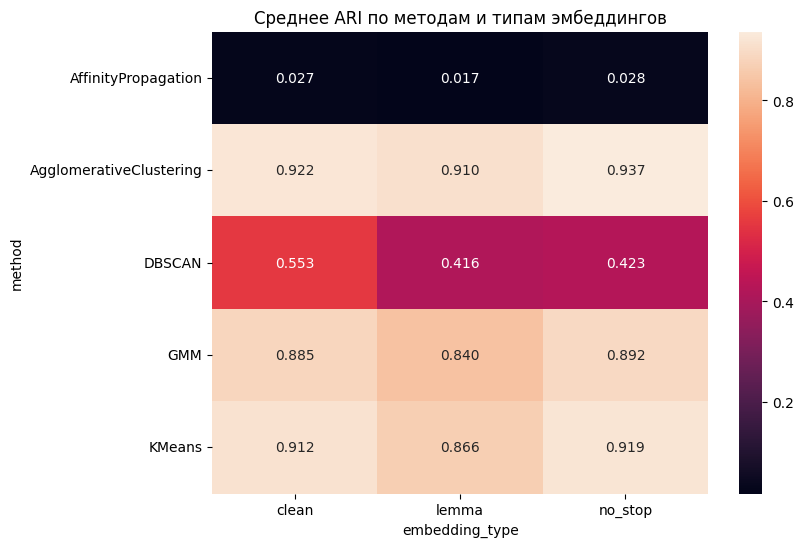

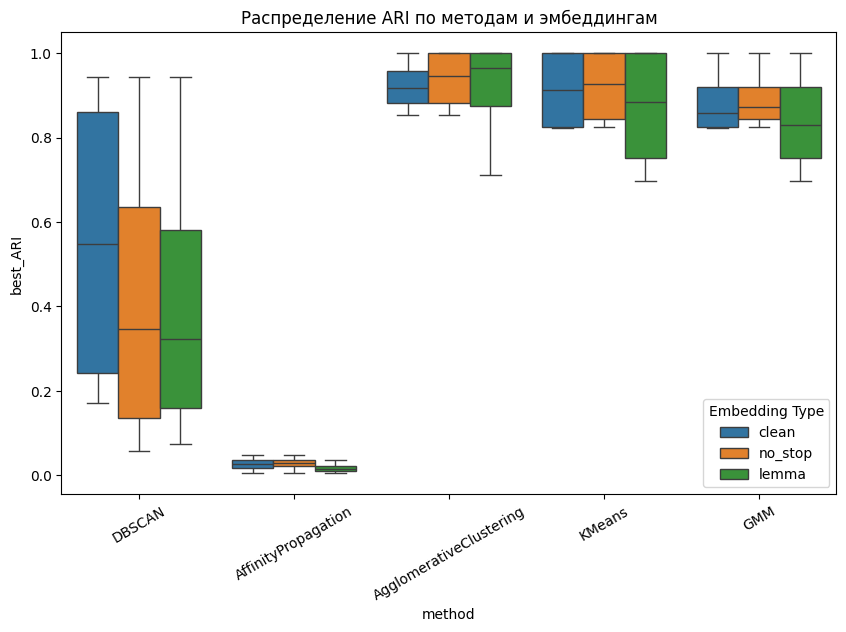

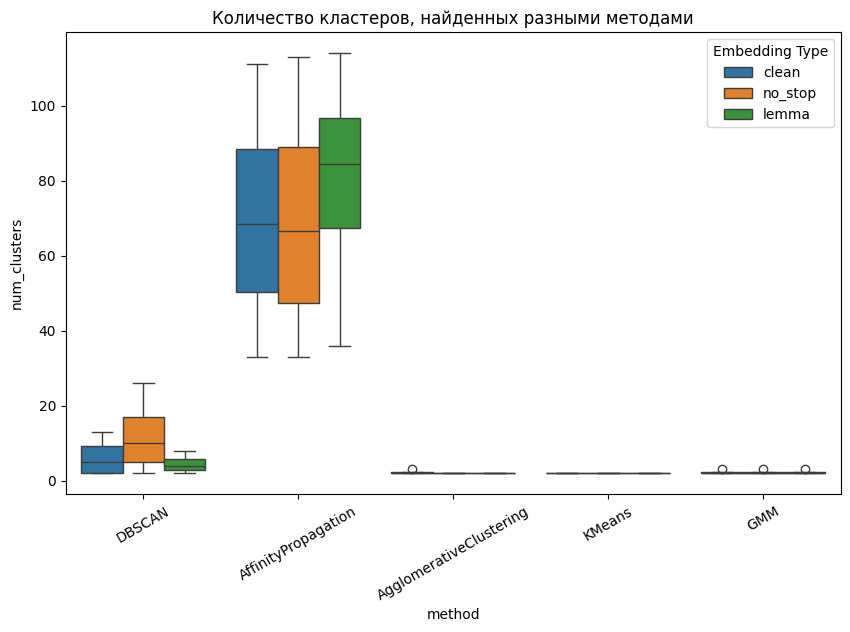

In [65]:
plt.figure(figsize=(8,6))
pivot = mean_ari.pivot(index="method", columns="embedding_type", values="mean_ARI")
sns.heatmap(pivot, annot=True, fmt=".3f")
plt.title("Среднее ARI по методам и типам эмбеддингов")
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(data=results_df, x="method", y="best_ARI", hue="embedding_type")
plt.title("Распределение ARI по методам и эмбеддингам")
plt.legend(title="Embedding Type")
plt.xticks(rotation=30)
plt.show()

plt.figure(figsize=(10,6))
sns.boxplot(data=results_df, x="method", y="num_clusters", hue="embedding_type")
plt.title("Количество кластеров, найденных разными методами")
plt.legend(title="Embedding Type")
plt.xticks(rotation=30)
plt.show()
